In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import xgboost as xgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2


In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
DEFAULT_PARAMS = {
    'booster':'gbtree',
    'grow_policy':'depthwise',
    'objective': 'binary:logistic',
    'verbosity': 0,
    'seed':2112,
    'eta': 0.005,
}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):
    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        100 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = xgb.DMatrix(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
            )

            model = xgb.train(
                params=model_params,
                dtrain=train_dset,
                num_boost_round=num_iterations,
            )
            y_pred = model.predict(xgb.DMatrix(valid_df.loc[:,input_cols]))
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = {
        "num_iterations": trial.suggest_int("num_iterations", 500, 4000),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "tree_method": trial.suggest_categorical("tree_method", ["approx", "hist"]),
    
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "gamma": trial.suggest_float("gamma", 1e-10, 1e1, log=True),
        "max_delta_step": trial.suggest_float("max_delta_step", 1e-10, 1e1, log=True),
    
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.05),
    
        "alpha": trial.suggest_float("alpha", 1e-10, 1e2, log=True),
        "lambda": trial.suggest_float("lambda", 1e-10, 1e2, log=True),
    
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1, scale_pos_weight]),
    }
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 7min 37s, sys: 3.2 s, total: 7min 40s
Wall time: 14.4 s


(0.5472904426294447, 0.025041000466892893)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-xgb-gbtree",
    direction='minimize',
    storage='sqlite:///iarc-xgb-gbtree.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=3000, 
        timeout=46800, # 13 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-09 00:12:40,390] Using an existing study with name 'iarc-xgb-gbtree' instead of creating a new one.


[I 2023-08-09 00:14:02,230] Trial 2 finished with value: 0.6931471805187998 and parameters: {'alpha': 10.997873723278502, 'colsample_bytree': 0.95, 'gamma': 4.520050985096925, 'lambda': 1.1189490162231196e-08, 'max_delta_step': 6.307806287992892e-08, 'max_depth': 3, 'min_child_weight': 33, 'num_iterations': 928, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'approx'}. Best is trial 0 with value: 0.6928176081587213.


[I 2023-08-09 00:14:47,178] Trial 3 finished with value: 0.6931471805187962 and parameters: {'alpha': 4.9636238821314e-09, 'colsample_bytree': 1.0, 'gamma': 0.0016043529937678862, 'lambda': 0.03617201912598886, 'max_delta_step': 3.40783306427725e-07, 'max_depth': 3, 'min_child_weight': 80, 'num_iterations': 2484, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 0 with value: 0.6928176081587213.


[I 2023-08-09 00:16:36,493] Trial 4 finished with value: 0.6931471805188 and parameters: {'alpha': 6.438195965398814e-05, 'colsample_bytree': 0.8, 'gamma': 4.6603767679571675, 'lambda': 3.6561400217418065e-09, 'max_delta_step': 1.0040817571072741e-07, 'max_depth': 6, 'min_child_weight': 59, 'num_iterations': 1035, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.95, 'tree_method': 'approx'}. Best is trial 0 with value: 0.6928176081587213.


[I 2023-08-09 00:19:27,766] Trial 5 finished with value: 0.6931472276066087 and parameters: {'alpha': 0.33259903528454776, 'colsample_bytree': 0.5, 'gamma': 4.347741341261464, 'lambda': 0.00015305852686913935, 'max_delta_step': 0.00046051162349045575, 'max_depth': 2, 'min_child_weight': 74, 'num_iterations': 2604, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.8500000000000001, 'tree_method': 'approx'}. Best is trial 0 with value: 0.6928176081587213.


[I 2023-08-09 00:22:49,172] Trial 6 finished with value: 0.6931432108722061 and parameters: {'alpha': 4.682277406111391e-09, 'colsample_bytree': 0.7, 'gamma': 1.6241906014657652e-06, 'lambda': 0.008701725065640225, 'max_delta_step': 1.1668399758416255e-06, 'max_depth': 2, 'min_child_weight': 13, 'num_iterations': 2601, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 0 with value: 0.6928176081587213.


[I 2023-08-09 00:26:43,901] Trial 7 finished with value: 0.6909456237522003 and parameters: {'alpha': 0.004283194093719647, 'colsample_bytree': 0.8, 'gamma': 8.503568360246933e-08, 'lambda': 3.241717065948369e-08, 'max_delta_step': 0.0010390371072040146, 'max_depth': 4, 'min_child_weight': 73, 'num_iterations': 3242, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.75, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:27:57,515] Trial 8 finished with value: 0.6920990135033709 and parameters: {'alpha': 10.612053094747997, 'colsample_bytree': 0.5, 'gamma': 4.807366082262773e-08, 'lambda': 0.26033891860170294, 'max_delta_step': 0.001885405816609216, 'max_depth': 2, 'min_child_weight': 16, 'num_iterations': 1012, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:28:14,396] Trial 9 finished with value: 0.6931471805188 and parameters: {'alpha': 0.1759132213693364, 'colsample_bytree': 0.8, 'gamma': 1.4785901912109495e-08, 'lambda': 0.0032858748630982936, 'max_delta_step': 7.754406774786614e-09, 'max_depth': 4, 'min_child_weight': 56, 'num_iterations': 889, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'hist'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:29:02,931] Trial 10 finished with value: 0.6992440798094012 and parameters: {'alpha': 0.05032257235793249, 'colsample_bytree': 0.75, 'gamma': 4.684095314491564e-08, 'lambda': 6.529692842851964e-07, 'max_delta_step': 0.0165292931862323, 'max_depth': 4, 'min_child_weight': 54, 'num_iterations': 2675, 'scale_pos_weight': 1, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:33:20,067] Trial 11 finished with value: 0.6931553892694307 and parameters: {'alpha': 0.0002553645075414392, 'colsample_bytree': 0.65, 'gamma': 1.1434544602680183e-10, 'lambda': 1.9834770298159762e-06, 'max_delta_step': 4.687073919875718, 'max_depth': 6, 'min_child_weight': 100, 'num_iterations': 3950, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:38:44,653] Trial 12 finished with value: 0.6930976922330744 and parameters: {'alpha': 79.15731720402097, 'colsample_bytree': 0.5, 'gamma': 1.734660550415071e-08, 'lambda': 19.67329509023487, 'max_delta_step': 2.7676922158621227e-05, 'max_depth': 5, 'min_child_weight': 1, 'num_iterations': 3796, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.8, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:40:35,923] Trial 13 finished with value: 0.6931471805188 and parameters: {'alpha': 0.002274473347523425, 'colsample_bytree': 0.6, 'gamma': 2.1214263399022418e-10, 'lambda': 67.50752078166389, 'max_delta_step': 6.790266317193867e-10, 'max_depth': 3, 'min_child_weight': 37, 'num_iterations': 1698, 'scale_pos_weight': 4.712962962962963, 'subsample': 1.0, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:44:09,293] Trial 14 finished with value: 0.6931471805188 and parameters: {'alpha': 31.523975068435732, 'colsample_bytree': 0.9, 'gamma': 8.634133250098002e-07, 'lambda': 1.7966335771920968e-10, 'max_delta_step': 0.03675028303103729, 'max_depth': 5, 'min_child_weight': 77, 'num_iterations': 3305, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:46:00,643] Trial 15 finished with value: 0.6931471805186342 and parameters: {'alpha': 0.004296542489741956, 'colsample_bytree': 0.6, 'gamma': 1.6570490050973296e-09, 'lambda': 1.4958161782743415, 'max_delta_step': 2.1030155012499683e-05, 'max_depth': 5, 'min_child_weight': 94, 'num_iterations': 1756, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'approx'}. Best is trial 7 with value: 0.6909456237522003.


[I 2023-08-09 00:50:17,571] Trial 16 finished with value: 0.46518963656232915 and parameters: {'alpha': 1.1399378079446608e-05, 'colsample_bytree': 0.7, 'gamma': 3.080701352965067e-07, 'lambda': 1.1587519178318171e-05, 'max_delta_step': 0.09559830988638204, 'max_depth': 3, 'min_child_weight': 43, 'num_iterations': 3335, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'approx'}. Best is trial 16 with value: 0.46518963656232915.


[I 2023-08-09 00:54:04,178] Trial 17 finished with value: 0.370577187976733 and parameters: {'alpha': 3.432479897973732e-06, 'colsample_bytree': 0.7, 'gamma': 1.1319538910839016e-06, 'lambda': 8.097200694233976e-07, 'max_delta_step': 0.6207990206593597, 'max_depth': 4, 'min_child_weight': 44, 'num_iterations': 3231, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'approx'}. Best is trial 17 with value: 0.370577187976733.


[I 2023-08-09 00:57:48,023] Trial 18 finished with value: 0.3810361939293215 and parameters: {'alpha': 2.218978496934964e-06, 'colsample_bytree': 0.7, 'gamma': 1.405291817955211e-05, 'lambda': 2.0656819067033937e-05, 'max_delta_step': 3.924615149333715, 'max_depth': 3, 'min_child_weight': 43, 'num_iterations': 3257, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'approx'}. Best is trial 17 with value: 0.370577187976733.


[I 2023-08-09 00:58:53,186] Trial 19 finished with value: 0.4129888722172176 and parameters: {'alpha': 2.6763271562174333e-07, 'colsample_bytree': 0.6, 'gamma': 2.8221052616096904e-05, 'lambda': 0.0002280517591980717, 'max_delta_step': 9.750521991049304, 'max_depth': 4, 'min_child_weight': 44, 'num_iterations': 3059, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 17 with value: 0.370577187976733.


[I 2023-08-09 01:03:13,785] Trial 20 finished with value: 0.31623904382606294 and parameters: {'alpha': 1.724827194742138e-06, 'colsample_bytree': 0.7, 'gamma': 0.0009610175815825226, 'lambda': 3.4546361058591857e-07, 'max_delta_step': 0.6777005307091004, 'max_depth': 3, 'min_child_weight': 31, 'num_iterations': 3556, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'approx'}. Best is trial 20 with value: 0.31623904382606294.


[I 2023-08-09 01:07:39,534] Trial 21 finished with value: 0.3657441820101074 and parameters: {'alpha': 1.1580273232793958e-07, 'colsample_bytree': 0.65, 'gamma': 0.0011438890888040966, 'lambda': 1.9111291821595194e-07, 'max_delta_step': 0.3395198977754914, 'max_depth': 5, 'min_child_weight': 31, 'num_iterations': 3670, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'approx'}. Best is trial 20 with value: 0.31623904382606294.


[I 2023-08-09 01:12:18,006] Trial 22 finished with value: 0.3493488514491452 and parameters: {'alpha': 1.2612451895398028e-07, 'colsample_bytree': 0.65, 'gamma': 0.0014025476555652593, 'lambda': 1.4996869532496794e-07, 'max_delta_step': 0.3312177941222469, 'max_depth': 5, 'min_child_weight': 29, 'num_iterations': 3773, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'approx'}. Best is trial 20 with value: 0.31623904382606294.


[I 2023-08-09 01:16:49,793] Trial 23 finished with value: 0.33334456776265725 and parameters: {'alpha': 1.206920843937941e-07, 'colsample_bytree': 0.65, 'gamma': 0.000982694226027679, 'lambda': 1.0275170741372067e-07, 'max_delta_step': 0.3873000737118254, 'max_depth': 5, 'min_child_weight': 27, 'num_iterations': 3670, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'approx'}. Best is trial 20 with value: 0.31623904382606294.


[I 2023-08-09 01:21:26,533] Trial 24 finished with value: 0.30488137421005157 and parameters: {'alpha': 2.0686000454521475e-10, 'colsample_bytree': 0.55, 'gamma': 0.0012397036713208893, 'lambda': 2.1555786778724163e-08, 'max_delta_step': 0.41316411974566386, 'max_depth': 6, 'min_child_weight': 23, 'num_iterations': 3623, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 24 with value: 0.30488137421005157.


[I 2023-08-09 01:27:11,049] Trial 25 finished with value: 0.6401901161626187 and parameters: {'alpha': 7.994252207626572e-10, 'colsample_bytree': 0.55, 'gamma': 0.012294228854909885, 'lambda': 2.7485202336782996e-09, 'max_delta_step': 0.012478280471248954, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3539, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 24 with value: 0.30488137421005157.


[I 2023-08-09 01:32:06,763] Trial 26 finished with value: 0.29179826197149944 and parameters: {'alpha': 1.0134737065284083e-10, 'colsample_bytree': 0.55, 'gamma': 0.00017282177433421242, 'lambda': 4.3611914770743826e-08, 'max_delta_step': 1.006519131691149, 'max_depth': 6, 'min_child_weight': 21, 'num_iterations': 3992, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 26 with value: 0.29179826197149944.


[I 2023-08-09 01:33:24,621] Trial 27 finished with value: 0.2865146277798787 and parameters: {'alpha': 1.2310994543987143e-10, 'colsample_bytree': 0.55, 'gamma': 0.00025191413411044606, 'lambda': 2.9377936777807492e-08, 'max_delta_step': 1.6670198571558599, 'max_depth': 6, 'min_child_weight': 20, 'num_iterations': 2922, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 27 with value: 0.2865146277798787.


[I 2023-08-09 01:34:41,550] Trial 28 finished with value: 0.2874219478925444 and parameters: {'alpha': 1.5185605743579995e-10, 'colsample_bytree': 0.55, 'gamma': 0.00017647871370657869, 'lambda': 1.902050315009421e-08, 'max_delta_step': 8.549860396340318, 'max_depth': 6, 'min_child_weight': 19, 'num_iterations': 2919, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 27 with value: 0.2865146277798787.


[I 2023-08-09 01:35:41,398] Trial 29 finished with value: 0.2845548118758011 and parameters: {'alpha': 1.0042582853722215e-10, 'colsample_bytree': 0.55, 'gamma': 9.784393693611821e-05, 'lambda': 6.983434753289629e-10, 'max_delta_step': 8.697542145504089, 'max_depth': 6, 'min_child_weight': 17, 'num_iterations': 2057, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 29 with value: 0.2845548118758011.


[I 2023-08-09 01:36:48,086] Trial 30 finished with value: 0.2715355371249631 and parameters: {'alpha': 1.4523684872281946e-09, 'colsample_bytree': 0.55, 'gamma': 1.0218542495015123e-05, 'lambda': 1.0742837443283035e-10, 'max_delta_step': 9.177504678930617, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 1993, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 30 with value: 0.2715355371249631.


[I 2023-08-09 01:38:07,106] Trial 31 finished with value: 0.2669935987676924 and parameters: {'alpha': 7.80132654229083e-09, 'colsample_bytree': 0.6, 'gamma': 6.732044585550455e-06, 'lambda': 5.743069510095798e-10, 'max_delta_step': 2.135626276850965, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2245, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:39:17,101] Trial 32 finished with value: 0.26911661122235286 and parameters: {'alpha': 1.493936642806695e-09, 'colsample_bytree': 0.6, 'gamma': 5.173758504988598e-06, 'lambda': 1.1003888005406606e-10, 'max_delta_step': 3.306493741282506, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:40:31,337] Trial 33 finished with value: 0.2674589334699211 and parameters: {'alpha': 2.726301872516449e-09, 'colsample_bytree': 0.6, 'gamma': 7.3684200114139224e-06, 'lambda': 1.0696030736633232e-10, 'max_delta_step': 9.03667614679543, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2002, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:42:04,805] Trial 34 finished with value: 0.5125249081750386 and parameters: {'alpha': 8.376584398439548e-09, 'colsample_bytree': 0.6, 'gamma': 4.970882659086195e-06, 'lambda': 1.109564695779903e-10, 'max_delta_step': 0.07704138611879872, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2203, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:43:34,572] Trial 35 finished with value: 0.3078399823159394 and parameters: {'alpha': 1.2486545160528561e-09, 'colsample_bytree': 0.6, 'gamma': 8.228243640941225e-06, 'lambda': 9.318676211585322e-10, 'max_delta_step': 2.075830676707455, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 1498, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:44:40,548] Trial 36 finished with value: 0.270880606773155 and parameters: {'alpha': 1.5239269685326914e-08, 'colsample_bytree': 0.5, 'gamma': 4.007228668723946e-06, 'lambda': 1.1918798231816403e-10, 'max_delta_step': 1.9974995224298746, 'max_depth': 5, 'min_child_weight': 10, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:45:37,941] Trial 37 finished with value: 0.521913853386142 and parameters: {'alpha': 1.6983598918278095e-08, 'colsample_bytree': 0.5, 'gamma': 4.002528080433337e-06, 'lambda': 4.14573285735322e-09, 'max_delta_step': 0.11048228567461987, 'max_depth': 5, 'min_child_weight': 8, 'num_iterations': 1465, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:46:51,425] Trial 38 finished with value: 0.27161464090924553 and parameters: {'alpha': 3.135495996450569e-08, 'colsample_bytree': 0.5, 'gamma': 3.434308968528147e-07, 'lambda': 5.439304351377083e-10, 'max_delta_step': 2.0285637801518424, 'max_depth': 5, 'min_child_weight': 12, 'num_iterations': 2342, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:47:54,506] Trial 39 finished with value: 0.6829078500769623 and parameters: {'alpha': 2.8845818023375993e-09, 'colsample_bytree': 0.75, 'gamma': 3.344210521503215e-05, 'lambda': 5.6323953100356206e-09, 'max_delta_step': 0.005897445877594129, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 1843, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:48:25,777] Trial 40 finished with value: 0.6507925823084908 and parameters: {'alpha': 2.478470492299243e-08, 'colsample_bytree': 0.9, 'gamma': 3.5586848169501824e-06, 'lambda': 1.800374256331887e-09, 'max_delta_step': 0.0550382797387205, 'max_depth': 5, 'min_child_weight': 63, 'num_iterations': 1293, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:49:33,053] Trial 41 finished with value: 0.43693010831053253 and parameters: {'alpha': 6.946557033301772e-10, 'colsample_bytree': 0.65, 'gamma': 4.1821365113952347e-07, 'lambda': 2.533425055912776e-10, 'max_delta_step': 1.5268026721852175, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 2377, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:50:41,029] Trial 42 finished with value: 0.2711938568208 and parameters: {'alpha': 3.4248177397027266e-09, 'colsample_bytree': 0.5, 'gamma': 2.207232330759169e-06, 'lambda': 1.3305386811306133e-10, 'max_delta_step': 8.04763215828557, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 2044, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:51:37,800] Trial 43 finished with value: 0.30586671179343144 and parameters: {'alpha': 4.845784038587418e-09, 'colsample_bytree': 0.5, 'gamma': 2.3026664785390934e-06, 'lambda': 6.070436312780378e-10, 'max_delta_step': 2.6837139682488265, 'max_depth': 6, 'min_child_weight': 24, 'num_iterations': 2148, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:52:42,143] Trial 44 finished with value: 0.45732807223610733 and parameters: {'alpha': 8.174537251828608e-09, 'colsample_bytree': 1.0, 'gamma': 4.258976497795798e-05, 'lambda': 1.046641865415662e-10, 'max_delta_step': 0.13454946224409597, 'max_depth': 6, 'min_child_weight': 15, 'num_iterations': 1880, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:53:46,194] Trial 45 finished with value: 0.2732896968996531 and parameters: {'alpha': 4.868478866735443e-10, 'colsample_bytree': 0.5, 'gamma': 1.6494460472239033e-06, 'lambda': 1.5773911592652319e-09, 'max_delta_step': 2.433602878166509, 'max_depth': 5, 'min_child_weight': 9, 'num_iterations': 1615, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.9, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:56:23,934] Trial 46 finished with value: 0.38149279739956826 and parameters: {'alpha': 3.004507941090326e-09, 'colsample_bytree': 0.6, 'gamma': 1.3124052738684088e-07, 'lambda': 7.831421915540225e-09, 'max_delta_step': 0.18101616827011785, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 2480, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:57:15,802] Trial 47 finished with value: 0.2899734059913955 and parameters: {'alpha': 2.6064901698604562e-08, 'colsample_bytree': 0.75, 'gamma': 9.870568204431277e-07, 'lambda': 5.270955204175822e-10, 'max_delta_step': 0.8987530435500545, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 1309, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.75, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:57:31,679] Trial 48 finished with value: 0.6929143286221897 and parameters: {'alpha': 2.313659062125721e-09, 'colsample_bytree': 0.5, 'gamma': 1.4075332231644053e-05, 'lambda': 3.106765683940639e-10, 'max_delta_step': 0.0004755420111296306, 'max_depth': 5, 'min_child_weight': 5, 'num_iterations': 527, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:58:44,403] Trial 49 finished with value: 0.6312216400815867 and parameters: {'alpha': 4.4407423240235793e-10, 'colsample_bytree': 0.6, 'gamma': 1.205261323015778e-07, 'lambda': 2.0860956834691866e-09, 'max_delta_step': 0.02434404106530646, 'max_depth': 6, 'min_child_weight': 35, 'num_iterations': 2696, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 01:59:47,155] Trial 50 finished with value: 0.27805373611628315 and parameters: {'alpha': 8.986690898663609e-09, 'colsample_bytree': 0.55, 'gamma': 4.790796918633533e-06, 'lambda': 8.270396033425547e-09, 'max_delta_step': 2.925091080916157, 'max_depth': 4, 'min_child_weight': 16, 'num_iterations': 2024, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:00:25,904] Trial 51 finished with value: 0.5001000700134236 and parameters: {'alpha': 4.863720095955327e-07, 'colsample_bytree': 0.5, 'gamma': 4.009409595725661e-07, 'lambda': 2.1992403461723715e-10, 'max_delta_step': 0.9320193935933364, 'max_depth': 5, 'min_child_weight': 67, 'num_iterations': 1850, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.75, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:01:33,643] Trial 52 finished with value: 0.27127249461496666 and parameters: {'alpha': 1.9938833629036953e-09, 'colsample_bytree': 0.55, 'gamma': 1.0890709068613354e-05, 'lambda': 1.3756076054576977e-10, 'max_delta_step': 9.402233810413836, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 2018, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:02:31,879] Trial 53 finished with value: 0.310517355739724 and parameters: {'alpha': 4.599724775733971e-08, 'colsample_bytree': 0.55, 'gamma': 1.7675127226518624e-06, 'lambda': 1.0486467766949246e-10, 'max_delta_step': 4.625292333275484, 'max_depth': 6, 'min_child_weight': 26, 'num_iterations': 2260, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:03:50,048] Trial 54 finished with value: 0.27250405458923 and parameters: {'alpha': 2.085854558597168e-09, 'colsample_bytree': 0.65, 'gamma': 1.2984303728568448e-05, 'lambda': 3.5527844671073983e-10, 'max_delta_step': 9.960619561345238, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 1669, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:04:35,636] Trial 55 finished with value: 0.693158486329218 and parameters: {'alpha': 1.1521888400520432e-08, 'colsample_bytree': 0.6, 'gamma': 8.13489228021544e-07, 'lambda': 1.1812698534547533e-09, 'max_delta_step': 0.21921668224721405, 'max_depth': 6, 'min_child_weight': 83, 'num_iterations': 2504, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:05:50,286] Trial 56 finished with value: 0.2731872331508766 and parameters: {'alpha': 4.1103758209909336e-10, 'colsample_bytree': 0.5, 'gamma': 4.0749187588535585e-05, 'lambda': 3.2289874410841577e-09, 'max_delta_step': 0.7885790203579855, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 2138, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:06:39,278] Trial 57 finished with value: 0.5717235112575884 and parameters: {'alpha': 6.41337022647578e-08, 'colsample_bytree': 0.6, 'gamma': 5.5614317151739405e-06, 'lambda': 3.2188676951105855e-10, 'max_delta_step': 4.939409407947588, 'max_depth': 5, 'min_child_weight': 18, 'num_iterations': 2015, 'scale_pos_weight': 1, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:07:20,957] Trial 58 finished with value: 0.34335104178561904 and parameters: {'alpha': 6.289297064826657e-09, 'colsample_bytree': 0.55, 'gamma': 2.189383660586956e-05, 'lambda': 8.704304480938735e-10, 'max_delta_step': 0.38957999775901525, 'max_depth': 2, 'min_child_weight': 11, 'num_iterations': 1527, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:08:37,855] Trial 59 finished with value: 0.26940369117266205 and parameters: {'alpha': 1.133333127161542e-09, 'colsample_bytree': 0.5, 'gamma': 2.603353331287552e-06, 'lambda': 9.967854268870232e-09, 'max_delta_step': 3.660031036134703, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 1912, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:09:35,452] Trial 60 finished with value: 0.622361170719006 and parameters: {'alpha': 3.483383340166265e-10, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.4607178272590443e-06, 'lambda': 4.9790822735178425e-09, 'max_delta_step': 0.04492237357928468, 'max_depth': 4, 'min_child_weight': 3, 'num_iterations': 1303, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:11:17,060] Trial 61 finished with value: 0.36649657781772904 and parameters: {'alpha': 9.84305004055644e-10, 'colsample_bytree': 0.5, 'gamma': 4.0849197780534075e-08, 'lambda': 1.1367497614644027e-08, 'max_delta_step': 0.20647251107607253, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2317, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:11:55,693] Trial 62 finished with value: 0.4617259798987453 and parameters: {'alpha': 3.769321104146381e-09, 'colsample_bytree': 0.5, 'gamma': 7.213805238486767e-06, 'lambda': 2.512719001629188e-10, 'max_delta_step': 2.8926055526125523, 'max_depth': 6, 'min_child_weight': 50, 'num_iterations': 1773, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:12:56,558] Trial 63 finished with value: 0.2836954980235033 and parameters: {'alpha': 1.2900808336896051e-09, 'colsample_bytree': 0.55, 'gamma': 7.348220456682406e-07, 'lambda': 9.181123778286093e-10, 'max_delta_step': 0.9175548101316281, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 1914, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:13:55,095] Trial 64 finished with value: 0.2927642289182418 and parameters: {'alpha': 1.6319398634954588e-08, 'colsample_bytree': 0.55, 'gamma': 1.3664590885191177e-06, 'lambda': 1.0479156688049811e-10, 'max_delta_step': 5.91040419931186, 'max_depth': 6, 'min_child_weight': 20, 'num_iterations': 2115, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:14:58,400] Trial 65 finished with value: 0.2711366336220316 and parameters: {'alpha': 3.36206732720289e-10, 'colsample_bytree': 0.6, 'gamma': 6.364211327404508e-05, 'lambda': 1.9584651260672237e-09, 'max_delta_step': 3.958263026042954, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 1628, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:15:47,713] Trial 66 finished with value: 0.2800626961389954 and parameters: {'alpha': 2.459473137631994e-10, 'colsample_bytree': 0.65, 'gamma': 6.393126984983153e-05, 'lambda': 5.477879216749627e-08, 'max_delta_step': 1.4528583726905742, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 1123, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:16:42,835] Trial 67 finished with value: 0.30514553413313694 and parameters: {'alpha': 7.843572479530652e-10, 'colsample_bytree': 0.6, 'gamma': 2.5098763956578746e-05, 'lambda': 2.2280475769718113e-09, 'max_delta_step': 0.6362682332093132, 'max_depth': 5, 'min_child_weight': 22, 'num_iterations': 1765, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:17:36,473] Trial 68 finished with value: 0.28460203841850384 and parameters: {'alpha': 2.3932151458019347e-10, 'colsample_bytree': 0.7, 'gamma': 8.700258752076354e-05, 'lambda': 1.536229845709798e-08, 'max_delta_step': 3.7890143778648255, 'max_depth': 6, 'min_child_weight': 17, 'num_iterations': 1637, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:18:43,173] Trial 69 finished with value: 0.4411849005740311 and parameters: {'alpha': 5.498538115057626e-09, 'colsample_bytree': 0.7, 'gamma': 0.0003788424666308917, 'lambda': 4.758132747016677e-10, 'max_delta_step': 0.508888708578116, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 1922, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:19:19,185] Trial 70 finished with value: 0.36663535346106974 and parameters: {'alpha': 4.719353190106686e-08, 'colsample_bytree': 0.65, 'gamma': 2.9247121576022693e-06, 'lambda': 1.507315686796074e-09, 'max_delta_step': 1.3731043420368778, 'max_depth': 5, 'min_child_weight': 38, 'num_iterations': 1401, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:21:14,824] Trial 71 finished with value: 0.28216316648009465 and parameters: {'alpha': 1.770649965872561e-08, 'colsample_bytree': 0.8, 'gamma': 2.129421840394377e-05, 'lambda': 3.983182639943298e-09, 'max_delta_step': 3.6711229901369635, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 2433, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:22:29,040] Trial 72 finished with value: 0.27034445705859506 and parameters: {'alpha': 1.5329759992964514e-09, 'colsample_bytree': 0.6, 'gamma': 9.784486699622068e-06, 'lambda': 2.586939089523113e-10, 'max_delta_step': 8.362584807451777, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 2225, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 31 with value: 0.2669935987676924.


[I 2023-08-09 02:23:50,911] Trial 73 finished with value: 0.26653801570636143 and parameters: {'alpha': 1.0115154190552658e-09, 'colsample_bytree': 0.6, 'gamma': 6.625072772748374e-06, 'lambda': 2.5950336433970745e-10, 'max_delta_step': 4.797816373025394, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 2184, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 73 with value: 0.26653801570636143.


[I 2023-08-09 02:25:12,002] Trial 74 finished with value: 0.2725778871621892 and parameters: {'alpha': 1.1446954551918558e-09, 'colsample_bytree': 0.65, 'gamma': 7.05211281881452e-06, 'lambda': 2.956135565170475e-10, 'max_delta_step': 4.069034205693563, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 2641, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 73 with value: 0.26653801570636143.


[I 2023-08-09 02:26:46,837] Trial 75 finished with value: 0.3172110185237333 and parameters: {'alpha': 1.7777326759308504e-10, 'colsample_bytree': 0.6, 'gamma': 5.4699098347260775e-05, 'lambda': 8.041689185853108e-10, 'max_delta_step': 0.2861038563405068, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 2240, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 73 with value: 0.26653801570636143.


[I 2023-08-09 02:28:25,580] Trial 76 finished with value: 0.26603864894068874 and parameters: {'alpha': 4.963021764814184e-10, 'colsample_bytree': 0.6, 'gamma': 1.2419144980362984e-05, 'lambda': 2.517315237578358e-10, 'max_delta_step': 1.8342668751625086, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2787, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:30:11,874] Trial 77 finished with value: 0.26790044600919993 and parameters: {'alpha': 6.255601958936646e-10, 'colsample_bytree': 0.6, 'gamma': 1.4011209747928909e-05, 'lambda': 4.5567448191664933e-10, 'max_delta_step': 1.9439107854029418, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 2810, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:33:04,771] Trial 78 finished with value: 0.4348431938639241 and parameters: {'alpha': 6.163528831579646e-10, 'colsample_bytree': 0.6, 'gamma': 1.69948587435252e-05, 'lambda': 5.952124201093516e-10, 'max_delta_step': 0.1106458919523878, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 2892, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:34:50,883] Trial 79 finished with value: 0.2681846849062019 and parameters: {'alpha': 1.208116950436597e-10, 'colsample_bytree': 0.65, 'gamma': 8.563676294185586e-06, 'lambda': 2.895102895435509e-10, 'max_delta_step': 1.289017618390917, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 2748, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:36:31,306] Trial 80 finished with value: 0.2665189733952367 and parameters: {'alpha': 1.5532533287804432e-10, 'colsample_bytree': 0.65, 'gamma': 0.00011655858552741876, 'lambda': 1.0572229788924809e-09, 'max_delta_step': 1.4838987939397492, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2778, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:37:57,366] Trial 81 finished with value: 0.3937551219408111 and parameters: {'alpha': 2.5596891773280107e-10, 'colsample_bytree': 0.65, 'gamma': 0.00011665738155627722, 'lambda': 1.169782049824845e-09, 'max_delta_step': 1.4207643585393293, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2783, 'scale_pos_weight': 1, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:40:04,778] Trial 82 finished with value: 0.278050208136172 and parameters: {'alpha': 1.2787689625295663e-10, 'colsample_bytree': 0.65, 'gamma': 3.660877908639715e-05, 'lambda': 4.63024989934188e-10, 'max_delta_step': 0.4355400640295957, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 2798, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:41:47,855] Trial 83 finished with value: 0.26695874825141114 and parameters: {'alpha': 8.328082979997086e-10, 'colsample_bytree': 0.7, 'gamma': 5.690322844322141e-06, 'lambda': 2.1107317647549966e-10, 'max_delta_step': 1.587625166956135, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3102, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 76 with value: 0.26603864894068874.


[I 2023-08-09 02:43:42,020] Trial 84 finished with value: 0.2657901299162033 and parameters: {'alpha': 6.570611659863438e-10, 'colsample_bytree': 0.7, 'gamma': 1.806165245716801e-05, 'lambda': 2.0686885825430924e-10, 'max_delta_step': 0.6155579761288197, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3060, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:45:41,871] Trial 85 finished with value: 0.266541371301029 and parameters: {'alpha': 1.0173918400542837e-10, 'colsample_bytree': 0.7, 'gamma': 2.276118963487985e-05, 'lambda': 3.307654130557313e-09, 'max_delta_step': 0.5527820034464952, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3122, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:47:23,869] Trial 86 finished with value: 0.48031457136494254 and parameters: {'alpha': 4.570059094784175e-10, 'colsample_bytree': 0.7, 'gamma': 0.00021216342672339658, 'lambda': 3.114510736315066e-09, 'max_delta_step': 0.07196693910142951, 'max_depth': 6, 'min_child_weight': 16, 'num_iterations': 3125, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:50:28,928] Trial 87 finished with value: 0.29355875061494574 and parameters: {'alpha': 1.0540363782774395e-10, 'colsample_bytree': 0.7, 'gamma': 0.0003655701417638665, 'lambda': 1.0131353358216599e-09, 'max_delta_step': 0.5516248481470085, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3407, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:52:28,396] Trial 88 finished with value: 0.3566145542249401 and parameters: {'alpha': 6.013893590683542e-10, 'colsample_bytree': 0.7, 'gamma': 2.1399576268988145e-05, 'lambda': 1.7891861733996225e-10, 'max_delta_step': 0.15798649005103763, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3023, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:57:06,898] Trial 89 finished with value: 0.3002868581258104 and parameters: {'alpha': 3.222011205143025e-09, 'colsample_bytree': 0.75, 'gamma': 9.878865443669196e-05, 'lambda': 5.358345137670237e-09, 'max_delta_step': 0.2991021068742361, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3107, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:58:28,445] Trial 90 finished with value: 0.28336262032320325 and parameters: {'alpha': 2.725329937127824e-10, 'colsample_bytree': 0.7, 'gamma': 3.212735631576256e-05, 'lambda': 5.02769151887585e-10, 'max_delta_step': 1.8952625423179854, 'max_depth': 6, 'min_child_weight': 19, 'num_iterations': 2575, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.95, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 02:59:56,586] Trial 91 finished with value: 0.2971249089549113 and parameters: {'alpha': 7.741129737046733e-10, 'colsample_bytree': 0.75, 'gamma': 1.449626248203255e-05, 'lambda': 2.0352390912688112e-10, 'max_delta_step': 0.728692145854608, 'max_depth': 6, 'min_child_weight': 24, 'num_iterations': 3402, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:01:44,940] Trial 92 finished with value: 0.26592518316289326 and parameters: {'alpha': 1.0425634393515331e-10, 'colsample_bytree': 0.65, 'gamma': 6.514270666912698e-06, 'lambda': 2.1567057313954483e-10, 'max_delta_step': 1.3644134944131232, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2987, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:03:48,748] Trial 93 finished with value: 0.27522934144317057 and parameters: {'alpha': 1.886065318914716e-10, 'colsample_bytree': 0.65, 'gamma': 4.4202589536326476e-06, 'lambda': 1.896741110790923e-09, 'max_delta_step': 1.9024576566289921, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3002, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:05:40,248] Trial 94 finished with value: 0.26725705636889374 and parameters: {'alpha': 5.216811588512036e-10, 'colsample_bytree': 0.65, 'gamma': 8.649407844306245e-06, 'lambda': 1.9220218880945852e-10, 'max_delta_step': 1.019126339407196, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3161, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:07:37,616] Trial 95 finished with value: 0.2667021341557307 and parameters: {'alpha': 2.1231909655221016e-09, 'colsample_bytree': 0.65, 'gamma': 7.16933820486904e-06, 'lambda': 2.270403609807082e-10, 'max_delta_step': 0.9777576599951872, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3359, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:09:57,438] Trial 96 finished with value: 0.284006545497531 and parameters: {'alpha': 3.331078595359791e-10, 'colsample_bytree': 0.65, 'gamma': 1.5209546729189213e-06, 'lambda': 1.9869546116885197e-10, 'max_delta_step': 0.31189894408735047, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3179, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:11:53,311] Trial 97 finished with value: 0.3601523347589775 and parameters: {'alpha': 1.7865812660350355e-10, 'colsample_bytree': 0.7, 'gamma': 4.2331440187330276e-05, 'lambda': 1.2280756731318017e-09, 'max_delta_step': 0.15166284327927793, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3330, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:13:21,604] Trial 98 finished with value: 0.27902396258763806 and parameters: {'alpha': 2.1806909229377677e-09, 'colsample_bytree': 0.65, 'gamma': 3.575467045692021e-06, 'lambda': 6.603984913760803e-10, 'max_delta_step': 0.8304300214217686, 'max_depth': 3, 'min_child_weight': 16, 'num_iterations': 3196, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:15:07,350] Trial 99 finished with value: 0.27582268920528924 and parameters: {'alpha': 4.68908416674889e-09, 'colsample_bytree': 0.75, 'gamma': 7.092124320424536e-06, 'lambda': 1.8158909659433282e-10, 'max_delta_step': 0.5028795196287028, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3412, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:16:06,491] Trial 100 finished with value: 0.693160996880586 and parameters: {'alpha': 1.0987129597293221e-10, 'colsample_bytree': 0.7, 'gamma': 2.1319981920505456e-05, 'lambda': 2.7953103669190787e-09, 'max_delta_step': 0.07954251657019691, 'max_depth': 2, 'min_child_weight': 86, 'num_iterations': 3275, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:19:58,809] Trial 101 finished with value: 0.615591493797472 and parameters: {'alpha': 1.6782618030282432e-09, 'colsample_bytree': 0.65, 'gamma': 9.97936416907732e-06, 'lambda': 3.829127188136668e-10, 'max_delta_step': 0.03287383237149034, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2926, 'scale_pos_weight': 1, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:21:46,458] Trial 102 finished with value: 0.26881990846800874 and parameters: {'alpha': 4.55323969308727e-10, 'colsample_bytree': 0.7, 'gamma': 4.56345981256744e-06, 'lambda': 1.0407111786283822e-10, 'max_delta_step': 5.294718650061842, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3511, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:23:49,381] Trial 103 finished with value: 0.2738734035127758 and parameters: {'alpha': 9.226162774823911e-10, 'colsample_bytree': 0.65, 'gamma': 2.289410527613772e-06, 'lambda': 1.9400709858895805e-10, 'max_delta_step': 1.1572856856393166, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 2988, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:25:24,650] Trial 104 finished with value: 0.26893987723079726 and parameters: {'alpha': 5.025993569915223e-09, 'colsample_bytree': 0.6, 'gamma': 1.0389252229887665e-06, 'lambda': 7.592665814397673e-10, 'max_delta_step': 6.013473963627319, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3093, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 84 with value: 0.2657901299162033.


[I 2023-08-09 03:27:05,420] Trial 105 finished with value: 0.2654938743721878 and parameters: {'alpha': 1.0053148588098127e-08, 'colsample_bytree': 0.65, 'gamma': 6.0111862660407856e-06, 'lambda': 3.9184374231435455e-10, 'max_delta_step': 2.5602077132871974, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2872, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:29:10,473] Trial 106 finished with value: 0.2758846610721155 and parameters: {'alpha': 8.205584348262881e-09, 'colsample_bytree': 0.65, 'gamma': 2.5729270703428556e-05, 'lambda': 1.1612615697165438e-09, 'max_delta_step': 2.278996890884498, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3146, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:30:54,528] Trial 107 finished with value: 0.26623319296387277 and parameters: {'alpha': 2.237864611045382e-10, 'colsample_bytree': 0.7, 'gamma': 5.730686380105028e-06, 'lambda': 3.622810269054714e-10, 'max_delta_step': 0.9015641982101806, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2861, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:32:36,388] Trial 108 finished with value: 0.3090881405302793 and parameters: {'alpha': 1.65526707572202e-10, 'colsample_bytree': 0.75, 'gamma': 3.0567410309624266e-06, 'lambda': 4.189776152940795e-10, 'max_delta_step': 0.27420297621469414, 'max_depth': 6, 'min_child_weight': 15, 'num_iterations': 2886, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:34:16,289] Trial 109 finished with value: 0.2832727849837637 and parameters: {'alpha': 2.297117011323515e-09, 'colsample_bytree': 0.7, 'gamma': 5.5253876428994355e-05, 'lambda': 1.7563065396183748e-09, 'max_delta_step': 0.5980193037768349, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 2557, 'scale_pos_weight': 4.712962962962963, 'subsample': 1.0, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:37:04,611] Trial 110 finished with value: 0.3665727783463377 and parameters: {'alpha': 2.4759278762488445e-10, 'colsample_bytree': 0.7, 'gamma': 5.506361603873632e-07, 'lambda': 6.6035199054675e-09, 'max_delta_step': 0.19725951026324876, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 2672, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:38:35,619] Trial 111 finished with value: 0.267623608745035 and parameters: {'alpha': 9.213334839621344e-10, 'colsample_bytree': 0.7, 'gamma': 1.4794362583575794e-06, 'lambda': 8.069471759932685e-10, 'max_delta_step': 2.3705555807295995, 'max_depth': 5, 'min_child_weight': 10, 'num_iterations': 2848, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:40:19,781] Trial 112 finished with value: 0.2661712319761156 and parameters: {'alpha': 4.6479586332159803e-10, 'colsample_bytree': 0.65, 'gamma': 1.2038548224360648e-05, 'lambda': 1.9879851743418673e-10, 'max_delta_step': 0.9509678261504904, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2951, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:42:15,198] Trial 113 finished with value: 0.27461917177536727 and parameters: {'alpha': 3.923104048884025e-10, 'colsample_bytree': 0.65, 'gamma': 1.9013333170001542e-05, 'lambda': 3.218793842757695e-10, 'max_delta_step': 1.0493936332585387, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2969, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:44:17,449] Trial 114 finished with value: 0.27343316556524794 and parameters: {'alpha': 1.4223686194302003e-09, 'colsample_bytree': 0.75, 'gamma': 6.300132978047738e-06, 'lambda': 2.9391623040121547e-09, 'max_delta_step': 2.9780039744331095, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3075, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:45:50,239] Trial 115 finished with value: 0.26598559155321067 and parameters: {'alpha': 1.9683506736650475e-10, 'colsample_bytree': 0.65, 'gamma': 1.599094158113253e-05, 'lambda': 1.7673411222553518e-10, 'max_delta_step': 5.719079880688182, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 2742, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:47:30,295] Trial 116 finished with value: 0.26664576858863964 and parameters: {'alpha': 1.033951913036485e-10, 'colsample_bytree': 0.7, 'gamma': 1.2448459541830104e-05, 'lambda': 1.633459763167217e-10, 'max_delta_step': 5.756139755906345, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2752, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:49:02,388] Trial 117 finished with value: 0.28039528862304314 and parameters: {'alpha': 2.010007708885584e-10, 'colsample_bytree': 0.65, 'gamma': 1.2674870858154308e-05, 'lambda': 1.0370431497767661e-10, 'max_delta_step': 0.49150020874474487, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 2699, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:50:46,098] Trial 118 finished with value: 0.2674951793417258 and parameters: {'alpha': 1.0490215332623956e-10, 'colsample_bytree': 0.65, 'gamma': 3.9407296903223616e-05, 'lambda': 3.704074222819762e-10, 'max_delta_step': 6.765138862887319, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 2741, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:52:18,293] Trial 119 finished with value: 0.26662383619893704 and parameters: {'alpha': 3.524102751485823e-10, 'colsample_bytree': 0.7, 'gamma': 7.623701300959374e-05, 'lambda': 1.5983222067026507e-10, 'max_delta_step': 9.783275262725924, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2848, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:56:14,712] Trial 120 finished with value: 0.2754447880971359 and parameters: {'alpha': 3.5118212343837185e-10, 'colsample_bytree': 0.7, 'gamma': 0.00011718242749901609, 'lambda': 5.802237348827067e-10, 'max_delta_step': 5.806364117702129, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 2941, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:57:16,394] Trial 121 finished with value: 0.6009873896732314 and parameters: {'alpha': 1.025898523287317e-10, 'colsample_bytree': 0.75, 'gamma': 6.24176071997359e-05, 'lambda': 1.3760178224370052e-09, 'max_delta_step': 3.9641251040318743, 'max_depth': 6, 'min_child_weight': 18, 'num_iterations': 2838, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 03:58:42,576] Trial 122 finished with value: 0.26658984404553726 and parameters: {'alpha': 2.2105659261549636e-10, 'colsample_bytree': 0.7, 'gamma': 3.2230483858884594e-05, 'lambda': 1.6171487104751478e-10, 'max_delta_step': 2.8442174395294915, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2623, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:00:05,653] Trial 123 finished with value: 0.2680335408293442 and parameters: {'alpha': 1.893934984333392e-10, 'colsample_bytree': 0.7, 'gamma': 2.6732193148399436e-05, 'lambda': 1.5412375576111867e-10, 'max_delta_step': 9.85188641170966, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 2584, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:00:55,281] Trial 124 finished with value: 0.4954348132194113 and parameters: {'alpha': 3.0746487010620066e-10, 'colsample_bytree': 0.7, 'gamma': 1.458352101355508e-05, 'lambda': 3.505755950694843e-10, 'max_delta_step': 2.8195425970562056, 'max_depth': 6, 'min_child_weight': 51, 'num_iterations': 2497, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:02:27,027] Trial 125 finished with value: 0.26675823288849254 and parameters: {'alpha': 4.672279833409443e-10, 'colsample_bytree': 0.7, 'gamma': 8.383539063198284e-05, 'lambda': 1.481495097860217e-10, 'max_delta_step': 5.0307294908325835, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2753, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:04:19,364] Trial 126 finished with value: 0.26977937426896065 and parameters: {'alpha': 1.8556821395842443e-10, 'colsample_bytree': 0.8, 'gamma': 0.0001455926046786805, 'lambda': 7.900226048603729e-10, 'max_delta_step': 3.072524440267537, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 2858, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:05:39,959] Trial 127 finished with value: 0.2696011007378377 and parameters: {'alpha': 6.234444789559953e-10, 'colsample_bytree': 0.75, 'gamma': 3.51316055222729e-05, 'lambda': 3.528821303619116e-10, 'max_delta_step': 5.829301253971273, 'max_depth': 4, 'min_child_weight': 11, 'num_iterations': 2626, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:07:27,178] Trial 128 finished with value: 0.2660215628378628 and parameters: {'alpha': 2.936762326984412e-10, 'colsample_bytree': 0.65, 'gamma': 1.5229670845082493e-05, 'lambda': 5.87033934008972e-10, 'max_delta_step': 1.475305811240985, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2987, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:09:47,857] Trial 129 finished with value: 0.3020890292936887 and parameters: {'alpha': 2.8761502939298904e-10, 'colsample_bytree': 0.65, 'gamma': 5.902949606866834e-05, 'lambda': 1.8715525537407678e-09, 'max_delta_step': 1.5770231217442676, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3041, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:11:43,215] Trial 130 finished with value: 0.2656211917941361 and parameters: {'alpha': 1.2266008314462542e-09, 'colsample_bytree': 0.65, 'gamma': 0.00018919426833440762, 'lambda': 4.499069758380372e-09, 'max_delta_step': 0.6924319843497382, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3228, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:14:04,579] Trial 131 finished with value: 0.27735080028826986 and parameters: {'alpha': 1.0928097423845466e-09, 'colsample_bytree': 0.6, 'gamma': 0.00040724911854075007, 'lambda': 9.592444128564034e-09, 'max_delta_step': 0.39191266149181814, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 2973, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:16:02,010] Trial 132 finished with value: 0.2663552430095951 and parameters: {'alpha': 6.544438397691746e-10, 'colsample_bytree': 0.65, 'gamma': 0.0001431305353515618, 'lambda': 4.1735602100225615e-09, 'max_delta_step': 0.6909589033925428, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3232, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:17:59,076] Trial 133 finished with value: 0.26669480818597846 and parameters: {'alpha': 6.848758890145472e-10, 'colsample_bytree': 0.65, 'gamma': 0.0001714463631995459, 'lambda': 3.755349443785589e-09, 'max_delta_step': 0.7502118967937151, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3271, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:19:36,403] Trial 134 finished with value: 0.2711605233645817 and parameters: {'alpha': 1.3614224186009967e-09, 'colsample_bytree': 0.65, 'gamma': 2.3590653805903493e-05, 'lambda': 4.0641966657360204e-08, 'max_delta_step': 1.2856829871845312, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3233, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:21:36,723] Trial 135 finished with value: 0.26618864964502187 and parameters: {'alpha': 1.7850382821499325e-10, 'colsample_bytree': 0.65, 'gamma': 0.0002121234875225657, 'lambda': 1.750300252815534e-08, 'max_delta_step': 0.6484282385848772, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3031, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:23:55,337] Trial 136 finished with value: 0.29499551070666735 and parameters: {'alpha': 7.143298834057615e-10, 'colsample_bytree': 0.65, 'gamma': 0.0005169796019515662, 'lambda': 1.8198481465716826e-08, 'max_delta_step': 0.27930020365937913, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3038, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:27:00,744] Trial 137 finished with value: 0.39129197018770207 and parameters: {'alpha': 3.6058282081897655e-09, 'colsample_bytree': 0.6, 'gamma': 0.00013130770791589357, 'lambda': 5.746206812667547e-09, 'max_delta_step': 0.13208809314473194, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 3189, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 105 with value: 0.2654938743721878.


[I 2023-08-09 04:29:17,030] Trial 138 finished with value: 0.26455176242742384 and parameters: {'alpha': 1.6994352608068032e-10, 'colsample_bytree': 0.65, 'gamma': 0.0002696679879623113, 'lambda': 1.0733197133336225e-08, 'max_delta_step': 0.5654183860930762, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3478, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:31:33,455] Trial 139 finished with value: 0.26682467994029846 and parameters: {'alpha': 4.744065725810053e-10, 'colsample_bytree': 0.65, 'gamma': 0.0005806442160334789, 'lambda': 1.239313004476854e-09, 'max_delta_step': 0.7653945044552758, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3839, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:33:32,544] Trial 140 finished with value: 0.30974729184145894 and parameters: {'alpha': 1.4986202836866403e-09, 'colsample_bytree': 0.6, 'gamma': 0.00018396667510784024, 'lambda': 2.888932418391065e-08, 'max_delta_step': 0.21859487623556864, 'max_depth': 6, 'min_child_weight': 15, 'num_iterations': 3459, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:34:25,386] Trial 141 finished with value: 0.6931595973603035 and parameters: {'alpha': 1.790151205713515e-10, 'colsample_bytree': 0.65, 'gamma': 0.00022371816233998588, 'lambda': 1.0294928939149101e-08, 'max_delta_step': 1.5097946149079498, 'max_depth': 6, 'min_child_weight': 98, 'num_iterations': 2935, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:36:19,268] Trial 142 finished with value: 0.27015871751100506 and parameters: {'alpha': 1.6317707055427372e-10, 'colsample_bytree': 0.65, 'gamma': 0.00029893819516423444, 'lambda': 1.7357930497222812e-08, 'max_delta_step': 0.4916528089003068, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3305, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:38:52,590] Trial 143 finished with value: 0.2783086229991562 and parameters: {'alpha': 3.0469950240595825e-10, 'colsample_bytree': 0.65, 'gamma': 0.0008416907900970018, 'lambda': 5.8113644832794326e-09, 'max_delta_step': 0.4046092044467526, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3065, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:41:02,235] Trial 144 finished with value: 0.26767389083214327 and parameters: {'alpha': 5.453909856847502e-10, 'colsample_bytree': 0.65, 'gamma': 0.0015434040346273762, 'lambda': 3.3970620069181317e-09, 'max_delta_step': 0.7498894098463611, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3625, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:43:10,097] Trial 145 finished with value: 0.439788207612704 and parameters: {'alpha': 9.38291835283495e-10, 'colsample_bytree': 0.6, 'gamma': 0.0002853222634059256, 'lambda': 6.319038386634716e-10, 'max_delta_step': 0.08538685844034895, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3224, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:45:18,124] Trial 146 finished with value: 0.6927587693388275 and parameters: {'alpha': 1.5344307902718308e-10, 'colsample_bytree': 0.65, 'gamma': 0.00010597045352388616, 'lambda': 1.7945250145771575e-09, 'max_delta_step': 9.821405644686876e-05, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3001, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:49:57,366] Trial 147 finished with value: 0.26890118364126886 and parameters: {'alpha': 2.589222881545954e-09, 'colsample_bytree': 0.6, 'gamma': 0.002692285790832403, 'lambda': 7.970259350189308e-08, 'max_delta_step': 1.8585101743519234, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3142, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:50:50,136] Trial 148 finished with value: 0.6924236238516147 and parameters: {'alpha': 1.0173919446860988e-10, 'colsample_bytree': 0.65, 'gamma': 3.7447187819493572e-06, 'lambda': 2.0327433064275057e-07, 'max_delta_step': 0.18772885620016813, 'max_depth': 6, 'min_child_weight': 70, 'num_iterations': 2896, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:52:39,754] Trial 149 finished with value: 0.36901185368839345 and parameters: {'alpha': 2.806351621319123e-10, 'colsample_bytree': 0.6, 'gamma': 1.628421117641076e-05, 'lambda': 9.947579706114894e-10, 'max_delta_step': 1.0554139475605984, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3066, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:55:06,180] Trial 150 finished with value: 0.6366728391597511 and parameters: {'alpha': 4.5316969438419654e-10, 'colsample_bytree': 0.65, 'gamma': 5.194439133793082e-05, 'lambda': 3.3230801928716715e-09, 'max_delta_step': 0.012642954603691216, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3536, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:56:25,961] Trial 151 finished with value: 0.27557782769449696 and parameters: {'alpha': 1.1266805074777173e-09, 'colsample_bytree': 0.6, 'gamma': 1.1566515668840015e-05, 'lambda': 5.757694477931912e-10, 'max_delta_step': 0.7049246839196701, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 2409, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:57:54,282] Trial 152 finished with value: 0.266861396920224 and parameters: {'alpha': 2.1299489826009785e-10, 'colsample_bytree': 0.65, 'gamma': 3.075084353504668e-05, 'lambda': 2.936350593467652e-10, 'max_delta_step': 2.510339857160654, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2692, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 04:59:38,615] Trial 153 finished with value: 0.2661406862298846 and parameters: {'alpha': 2.193042440320156e-10, 'colsample_bytree': 0.7, 'gamma': 8.739851283593387e-06, 'lambda': 4.731223529257989e-10, 'max_delta_step': 1.2154926596952977, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2823, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:01:42,409] Trial 154 finished with value: 0.2794896530540012 and parameters: {'alpha': 5.856287667331791e-10, 'colsample_bytree': 0.65, 'gamma': 4.659610791973162e-06, 'lambda': 2.228493304366515e-09, 'max_delta_step': 0.3783058120343436, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 2811, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:02:39,712] Trial 155 finished with value: 0.5293759180919599 and parameters: {'alpha': 2.985214482568714e-10, 'colsample_bytree': 0.95, 'gamma': 2.7993637059992043e-06, 'lambda': 3.389589953300946e-06, 'max_delta_step': 1.5411308304788383, 'max_depth': 6, 'min_child_weight': 59, 'num_iterations': 2950, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:05:00,438] Trial 156 finished with value: 0.30214471135509535 and parameters: {'alpha': 1.7844370395267715e-10, 'colsample_bytree': 0.65, 'gamma': 9.036318143453445e-06, 'lambda': 9.070203792476753e-10, 'max_delta_step': 1.0313969182968639, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 2893, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:07:23,819] Trial 157 finished with value: 0.6832115253449029 and parameters: {'alpha': 1.0173057586473709e-10, 'colsample_bytree': 0.7, 'gamma': 1.8846191710103818e-05, 'lambda': 4.5123564017453956e-10, 'max_delta_step': 0.0025083381141859464, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3001, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:09:24,293] Trial 158 finished with value: 0.27292316157770746 and parameters: {'alpha': 8.613085352642967e-10, 'colsample_bytree': 0.7, 'gamma': 7.203259207574902e-06, 'lambda': 1.3305481776401196e-08, 'max_delta_step': 0.44853268760766757, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 2806, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.75, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:11:17,065] Trial 159 finished with value: 0.2697190411729762 and parameters: {'alpha': 9.630849551309356e-06, 'colsample_bytree': 0.65, 'gamma': 5.035291590015813e-05, 'lambda': 2.9398461727036204e-10, 'max_delta_step': 3.7565034437898452, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3729, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:13:24,046] Trial 160 finished with value: 0.26826021376153003 and parameters: {'alpha': 1.8082735755369425e-09, 'colsample_bytree': 0.65, 'gamma': 1.107253004311795e-05, 'lambda': 2.5026067142874838e-08, 'max_delta_step': 0.6401564836526168, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3120, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.7, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:15:41,369] Trial 161 finished with value: 0.31408483896574924 and parameters: {'alpha': 3.528985349139253e-10, 'colsample_bytree': 0.65, 'gamma': 2.0665207308790466e-06, 'lambda': 1.1521139213220714e-09, 'max_delta_step': 0.26087341969801375, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 2719, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:17:08,653] Trial 162 finished with value: 0.2665618540805783 and parameters: {'alpha': 2.715029009051195e-10, 'colsample_bytree': 0.7, 'gamma': 3.1420072878444e-05, 'lambda': 2.311280663305967e-10, 'max_delta_step': 2.659673236766649, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 2635, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:18:35,337] Trial 163 finished with value: 0.2704173152154861 and parameters: {'alpha': 1.6622291896797917e-10, 'colsample_bytree': 0.7, 'gamma': 8.26452344895125e-05, 'lambda': 5.252023520916593e-10, 'max_delta_step': 2.154386803653664, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 2889, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:20:14,389] Trial 164 finished with value: 0.26640446805233964 and parameters: {'alpha': 4.6253422575457546e-10, 'colsample_bytree': 0.7, 'gamma': 1.8537073183148786e-05, 'lambda': 1.0004932485621524e-10, 'max_delta_step': 1.1695041019174015, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 2965, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:21:58,018] Trial 165 finished with value: 0.2663170638371134 and parameters: {'alpha': 5.675241220858777e-10, 'colsample_bytree': 0.7, 'gamma': 4.796939299274167e-06, 'lambda': 1.1898304017074534e-10, 'max_delta_step': 1.342146003351403, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2940, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:23:51,266] Trial 166 finished with value: 0.2694598245763068 and parameters: {'alpha': 7.163169979706563e-10, 'colsample_bytree': 0.65, 'gamma': 7.059980159503915e-06, 'lambda': 1.0609294388429032e-10, 'max_delta_step': 1.219757860648984, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 2956, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:24:58,383] Trial 167 finished with value: 0.3730997368011513 and parameters: {'alpha': 3.886819913654698e-09, 'colsample_bytree': 0.7, 'gamma': 4.7578899729565165e-06, 'lambda': 2.7475185290165377e-10, 'max_delta_step': 1.288825279990571, 'max_depth': 6, 'min_child_weight': 39, 'num_iterations': 3024, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:26:53,943] Trial 168 finished with value: 0.5299681429740322 and parameters: {'alpha': 1.5806055308995187e-09, 'colsample_bytree': 0.7, 'gamma': 3.183319888354223e-06, 'lambda': 1.1458048733054646e-10, 'max_delta_step': 0.05280475398780274, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 2792, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:28:25,365] Trial 169 finished with value: 0.26807657118789624 and parameters: {'alpha': 4.796986682104586e-10, 'colsample_bytree': 0.65, 'gamma': 1.619562629552537e-05, 'lambda': 4.1983757670563926e-10, 'max_delta_step': 3.8113155288410607, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 2832, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:33:06,423] Trial 170 finished with value: 0.36827024420900684 and parameters: {'alpha': 1.0448338229616304e-08, 'colsample_bytree': 0.6, 'gamma': 1.833955661489802e-06, 'lambda': 2.3565649189024436e-10, 'max_delta_step': 1.9467033414957409, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 2920, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:34:27,409] Trial 171 finished with value: 0.2717749669611459 and parameters: {'alpha': 8.465942169754463e-10, 'colsample_bytree': 0.65, 'gamma': 5.672844103929395e-06, 'lambda': 1.0256609694784589e-10, 'max_delta_step': 0.835785388601241, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 2311, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:36:29,290] Trial 172 finished with value: 0.26592071777613885 and parameters: {'alpha': 1.0225799626122852e-10, 'colsample_bytree': 0.7, 'gamma': 1.0666530100946867e-05, 'lambda': 8.190821293586397e-10, 'max_delta_step': 0.5547119314950602, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3193, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:38:23,688] Trial 173 finished with value: 0.2648131318289091 and parameters: {'alpha': 3.1738581901004577e-10, 'colsample_bytree': 0.7, 'gamma': 9.246758470126587e-06, 'lambda': 9.78481840942035e-10, 'max_delta_step': 0.6127283428941788, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3186, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:40:41,921] Trial 174 finished with value: 0.2747693162917534 and parameters: {'alpha': 3.731894072942656e-10, 'colsample_bytree': 0.7, 'gamma': 1.1332052556077087e-05, 'lambda': 7.864027066771363e-10, 'max_delta_step': 0.35303172196389626, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3335, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:42:37,364] Trial 175 finished with value: 0.26489351372790715 and parameters: {'alpha': 1.9698817807097616e-10, 'colsample_bytree': 0.7, 'gamma': 1.4999535696232783e-05, 'lambda': 1.7670965323449469e-09, 'max_delta_step': 0.5958922112584326, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3217, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:44:36,007] Trial 176 finished with value: 0.3556646019701183 and parameters: {'alpha': 0.00013135364008222695, 'colsample_bytree': 0.7, 'gamma': 1.6417280461623396e-05, 'lambda': 1.7326234361307624e-09, 'max_delta_step': 0.15309969643266563, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3200, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:46:34,488] Trial 177 finished with value: 0.2660563665152012 and parameters: {'alpha': 2.415189531729497e-10, 'colsample_bytree': 0.7, 'gamma': 1.0376424168921873e-05, 'lambda': 6.641493241975032e-10, 'max_delta_step': 0.5582013688425441, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3263, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:49:19,968] Trial 178 finished with value: 0.2788406713773846 and parameters: {'alpha': 2.252239374656486e-10, 'colsample_bytree': 0.7, 'gamma': 4.3195480318844855e-06, 'lambda': 6.551183909800562e-09, 'max_delta_step': 0.5371263737425699, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 3253, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:51:16,809] Trial 179 finished with value: 0.31702481743282707 and parameters: {'alpha': 1.5423841698116578e-10, 'colsample_bytree': 0.75, 'gamma': 9.345654524234697e-06, 'lambda': 6.068488795894452e-10, 'max_delta_step': 0.2078194924688974, 'max_depth': 6, 'min_child_weight': 15, 'num_iterations': 3436, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:53:13,954] Trial 180 finished with value: 0.6042805612060043 and parameters: {'alpha': 2.910733711452774e-10, 'colsample_bytree': 0.7, 'gamma': 9.445145529165386e-06, 'lambda': 2.2155001684795326e-09, 'max_delta_step': 0.02249763616367805, 'max_depth': 3, 'min_child_weight': 5, 'num_iterations': 3295, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:55:03,678] Trial 181 finished with value: 0.4041777699999299 and parameters: {'alpha': 3.7452650644080117e-07, 'colsample_bytree': 0.75, 'gamma': 2.9861063332282594e-06, 'lambda': 0.0008266505738948054, 'max_delta_step': 0.11651046567576033, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3159, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:56:49,050] Trial 182 finished with value: 0.26605731983917424 and parameters: {'alpha': 5.034784665889741e-10, 'colsample_bytree': 0.7, 'gamma': 1.6215672129426748e-05, 'lambda': 5.051642615472578e-10, 'max_delta_step': 0.8365388273535045, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3068, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 05:58:45,858] Trial 183 finished with value: 0.2648869675859066 and parameters: {'alpha': 4.5711269342351214e-10, 'colsample_bytree': 0.7, 'gamma': 5.861837218643357e-06, 'lambda': 5.070890861857284e-10, 'max_delta_step': 0.6223606657625473, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3230, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:00:51,269] Trial 184 finished with value: 0.27953387447077893 and parameters: {'alpha': 1.0250173184638475e-10, 'colsample_bytree': 0.7, 'gamma': 6.1507896107283465e-06, 'lambda': 4.2436811671792616e-10, 'max_delta_step': 0.3498248538392782, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3374, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:02:57,802] Trial 185 finished with value: 0.26741847520988843 and parameters: {'alpha': 2.4828713543187103e-10, 'colsample_bytree': 0.7, 'gamma': 1.3200219723107607e-05, 'lambda': 7.68913411855175e-10, 'max_delta_step': 0.7977996682174927, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3061, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:05:04,147] Trial 186 finished with value: 0.26880460257103117 and parameters: {'alpha': 4.345179259301687e-10, 'colsample_bytree': 0.7, 'gamma': 4.30717005670646e-06, 'lambda': 1.1870777915188276e-09, 'max_delta_step': 0.4981561658669061, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3092, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:06:57,804] Trial 187 finished with value: 0.27264394375450574 and parameters: {'alpha': 1.6788063080727863e-10, 'colsample_bytree': 0.7, 'gamma': 2.2636929019413097e-05, 'lambda': 3.8470030706417865e-10, 'max_delta_step': 1.0407381253072734, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3483, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.8, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:09:21,010] Trial 188 finished with value: 0.30544421794553295 and parameters: {'alpha': 9.266864688730839e-10, 'colsample_bytree': 0.75, 'gamma': 7.968645768855803e-06, 'lambda': 2.0980912477638542e-10, 'max_delta_step': 0.24384157032694329, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3156, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:11:13,830] Trial 189 finished with value: 0.6931462679639501 and parameters: {'alpha': 3.5774094766537665e-10, 'colsample_bytree': 0.7, 'gamma': 1.1056825727851989e-06, 'lambda': 2.4709582426616142e-05, 'max_delta_step': 2.162398387739995e-07, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3253, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:13:34,674] Trial 190 finished with value: 0.29930803237450904 and parameters: {'alpha': 5.706522635522657e-10, 'colsample_bytree': 0.7, 'gamma': 2.2012692881083584e-06, 'lambda': 6.433746196802996e-10, 'max_delta_step': 2.244769994805374, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3014, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:15:41,927] Trial 191 finished with value: 0.2648619167859887 and parameters: {'alpha': 2.2733562221791137e-09, 'colsample_bytree': 0.7, 'gamma': 2.7337048607892098e-05, 'lambda': 1.6567427319189252e-09, 'max_delta_step': 0.5848097710777143, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3367, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:17:48,281] Trial 192 finished with value: 0.2646534405565918 and parameters: {'alpha': 1.779771369199047e-07, 'colsample_bytree': 0.7, 'gamma': 2.4752286661687988e-05, 'lambda': 1.4493274013340037e-09, 'max_delta_step': 0.5899518058224827, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3335, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:20:10,240] Trial 193 finished with value: 0.2650369789820343 and parameters: {'alpha': 2.6750486729823925e-07, 'colsample_bytree': 0.7, 'gamma': 3.267552368843379e-05, 'lambda': 1.8214682649214165e-09, 'max_delta_step': 0.5725407477339276, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3353, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:23:03,014] Trial 194 finished with value: 0.29081240419498844 and parameters: {'alpha': 1.806350787503835e-07, 'colsample_bytree': 0.7, 'gamma': 3.7312321055011696e-05, 'lambda': 1.9748213334445194e-09, 'max_delta_step': 0.29450538465684134, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3360, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:24:59,644] Trial 195 finished with value: 0.26563399263049015 and parameters: {'alpha': 8.182997387192271e-08, 'colsample_bytree': 0.7, 'gamma': 2.7716022054857053e-05, 'lambda': 1.5342284203818567e-09, 'max_delta_step': 0.6083443611008265, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3344, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:27:47,606] Trial 196 finished with value: 0.27802885421726503 and parameters: {'alpha': 1.954776670390792e-07, 'colsample_bytree': 0.7, 'gamma': 2.542089864075122e-05, 'lambda': 1.4257739817055855e-09, 'max_delta_step': 0.3459313485496452, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3323, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:29:41,697] Trial 197 finished with value: 0.6931231627590946 and parameters: {'alpha': 7.11928418153925e-08, 'colsample_bytree': 0.75, 'gamma': 4.72027496140055e-05, 'lambda': 2.907318531432761e-09, 'max_delta_step': 5.280379493579963e-06, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 3428, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:32:02,333] Trial 198 finished with value: 0.660917985195468 and parameters: {'alpha': 5.614694760863976e-09, 'colsample_bytree': 0.7, 'gamma': 1.4954658779366076e-05, 'lambda': 9.646191774848556e-10, 'max_delta_step': 0.0068150948100176596, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3605, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:34:44,819] Trial 199 finished with value: 0.4122717193454124 and parameters: {'alpha': 6.699433405212317e-07, 'colsample_bytree': 0.7, 'gamma': 2.798521657999543e-05, 'lambda': 1.8641160295109463e-09, 'max_delta_step': 0.10230245141147927, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3307, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:36:42,278] Trial 200 finished with value: 0.2681242585740856 and parameters: {'alpha': 1.1755266785711599e-07, 'colsample_bytree': 0.7, 'gamma': 1.1987705965391423e-05, 'lambda': 1.1742350681716662e-09, 'max_delta_step': 0.5114308353437986, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3459, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:39:15,990] Trial 201 finished with value: 0.3422015054221671 and parameters: {'alpha': 3.238456176134641e-07, 'colsample_bytree': 0.7, 'gamma': 4.381657219644096e-05, 'lambda': 4.663381023622029e-09, 'max_delta_step': 0.1497441699640057, 'max_depth': 4, 'min_child_weight': 5, 'num_iterations': 3574, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:41:23,798] Trial 202 finished with value: 0.2651307545001799 and parameters: {'alpha': 7.073399849054897e-07, 'colsample_bytree': 0.7, 'gamma': 1.9247583534247443e-05, 'lambda': 7.858613023973175e-09, 'max_delta_step': 0.7392098415884844, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3384, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:43:29,690] Trial 203 finished with value: 0.2655630233708409 and parameters: {'alpha': 3.500384144219058e-08, 'colsample_bytree': 0.7, 'gamma': 1.762460881892201e-05, 'lambda': 6.732359263259019e-09, 'max_delta_step': 0.5487015560440109, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3386, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:45:38,805] Trial 204 finished with value: 0.2651708114825454 and parameters: {'alpha': 4.125972959156936e-08, 'colsample_bytree': 0.7, 'gamma': 2.4107635221547297e-05, 'lambda': 8.006986795721275e-09, 'max_delta_step': 0.5527602034444346, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3512, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:47:37,815] Trial 205 finished with value: 0.26781165581347266 and parameters: {'alpha': 3.888287043306493e-08, 'colsample_bytree': 0.75, 'gamma': 2.271058262400612e-05, 'lambda': 9.124938100815614e-09, 'max_delta_step': 0.5196730662377225, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3525, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:49:12,336] Trial 206 finished with value: 0.3002937841364847 and parameters: {'alpha': 2.2606881858761148e-08, 'colsample_bytree': 0.7, 'gamma': 6.269138432128424e-05, 'lambda': 4.5085687145366255e-09, 'max_delta_step': 0.250987999037111, 'max_depth': 2, 'min_child_weight': 9, 'num_iterations': 3353, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:51:14,176] Trial 207 finished with value: 0.2646473327359121 and parameters: {'alpha': 5.5202624237643776e-08, 'colsample_bytree': 0.7, 'gamma': 3.164293709869066e-05, 'lambda': 7.372084279393123e-09, 'max_delta_step': 0.6446207853716002, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3378, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:55:53,651] Trial 208 finished with value: 0.43947439967977836 and parameters: {'alpha': 7.823564271668413e-08, 'colsample_bytree': 0.7, 'gamma': 3.6888368137265826e-05, 'lambda': 1.0362433416580225e-08, 'max_delta_step': 0.3799858013007561, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3408, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 06:58:26,789] Trial 209 finished with value: 0.310291441814679 and parameters: {'alpha': 3.9343466956960427e-08, 'colsample_bytree': 0.7, 'gamma': 7.43804166380004e-05, 'lambda': 6.355078323171292e-09, 'max_delta_step': 0.19952849772056647, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3497, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:00:57,923] Trial 210 finished with value: 0.27210911443879 and parameters: {'alpha': 1.890547330081815e-08, 'colsample_bytree': 0.7, 'gamma': 3.097591440177831e-05, 'lambda': 3.411046490730346e-09, 'max_delta_step': 0.611238205868329, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3249, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:02:36,883] Trial 211 finished with value: 0.270672722396508 and parameters: {'alpha': 9.464484721516247e-08, 'colsample_bytree': 0.7, 'gamma': 1.9885594563740584e-05, 'lambda': 1.3874351490290012e-08, 'max_delta_step': 1.7798339811925405, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3383, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:04:33,977] Trial 212 finished with value: 0.26498505211493434 and parameters: {'alpha': 4.580782788867093e-08, 'colsample_bytree': 0.7, 'gamma': 1.573556618776738e-05, 'lambda': 2.570402825880387e-09, 'max_delta_step': 0.7180976644894811, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3293, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:06:39,475] Trial 213 finished with value: 0.2668663659850698 and parameters: {'alpha': 3.182315370976767e-08, 'colsample_bytree': 0.7, 'gamma': 1.8569612690613144e-05, 'lambda': 2.6226160239920594e-08, 'max_delta_step': 0.5051899011156048, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3309, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:08:29,296] Trial 214 finished with value: 0.6920586709635173 and parameters: {'alpha': 7.918023794234171e-08, 'colsample_bytree': 0.7, 'gamma': 1.001888686021104e-05, 'lambda': 7.674727441957852e-09, 'max_delta_step': 0.00024228090507314535, 'max_depth': 6, 'min_child_weight': 31, 'num_iterations': 3678, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:10:17,307] Trial 215 finished with value: 0.2669630045745102 and parameters: {'alpha': 1.8413160278679309e-07, 'colsample_bytree': 0.75, 'gamma': 2.9546778696752334e-05, 'lambda': 2.8737150704463955e-09, 'max_delta_step': 0.7382046608996436, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3209, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:12:46,382] Trial 216 finished with value: 0.4657775537896065 and parameters: {'alpha': 3.953246499298606e-08, 'colsample_bytree': 0.7, 'gamma': 4.0075904948460106e-05, 'lambda': 4.024389462025368e-08, 'max_delta_step': 0.06708840333184111, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3449, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:15:30,549] Trial 217 finished with value: 0.28257416969206167 and parameters: {'alpha': 4.954050971898556e-08, 'colsample_bytree': 0.7, 'gamma': 1.449981232894564e-05, 'lambda': 5.567792260637928e-09, 'max_delta_step': 0.3155747212602977, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3280, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.8500000000000001, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:17:24,112] Trial 218 finished with value: 0.2672204861841921 and parameters: {'alpha': 1.3319888429811851e-08, 'colsample_bytree': 0.7, 'gamma': 7.650981559517542e-05, 'lambda': 2.0750068501802105e-09, 'max_delta_step': 1.470610394332371, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3373, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:18:32,607] Trial 219 finished with value: 0.6931471805188 and parameters: {'alpha': 2.7323678040822485e-08, 'colsample_bytree': 0.7, 'gamma': 9.034465772593693e-06, 'lambda': 6.749550702706785e-08, 'max_delta_step': 6.0612097499635655e-09, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3528, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:20:24,803] Trial 220 finished with value: 0.2663789602042735 and parameters: {'alpha': 1.155727015437735e-07, 'colsample_bytree': 0.75, 'gamma': 2.2622412320398996e-05, 'lambda': 9.413632233425998e-07, 'max_delta_step': 0.8382140783794559, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3204, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:23:10,148] Trial 221 finished with value: 0.2735664966206897 and parameters: {'alpha': 5.826325862727037e-08, 'colsample_bytree': 0.7, 'gamma': 4.9062342026020663e-05, 'lambda': 2.897592481751317e-09, 'max_delta_step': 0.44030056249254085, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3341, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:24:59,621] Trial 222 finished with value: 0.26626159400673477 and parameters: {'alpha': 6.595991281987613e-07, 'colsample_bytree': 0.7, 'gamma': 1.4718373335751066e-05, 'lambda': 1.459804218675047e-09, 'max_delta_step': 0.9200550506777712, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3272, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:26:50,276] Trial 223 finished with value: 0.2658061792869689 and parameters: {'alpha': 2.2273785287408311e-07, 'colsample_bytree': 0.7, 'gamma': 1.802282221063276e-05, 'lambda': 0.02718870466364956, 'max_delta_step': 0.6721498988047283, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3173, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:28:39,003] Trial 224 finished with value: 0.26857644509088446 and parameters: {'alpha': 2.767529569611198e-07, 'colsample_bytree': 0.7, 'gamma': 9.223343540241269e-06, 'lambda': 4.5242029933170596, 'max_delta_step': 0.6067362868984912, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3171, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:31:16,893] Trial 225 finished with value: 0.2958830220028649 and parameters: {'alpha': 1.674028258099761e-07, 'colsample_bytree': 0.7, 'gamma': 2.3414400324721848e-05, 'lambda': 1.107882994647542e-08, 'max_delta_step': 0.2447511986613522, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3420, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:33:05,863] Trial 226 finished with value: 0.266033633493311 and parameters: {'alpha': 9.891973019803211e-08, 'colsample_bytree': 0.7, 'gamma': 6.367214288400776e-06, 'lambda': 0.2609202800030999, 'max_delta_step': 1.6665143607821835, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3232, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:34:02,590] Trial 227 finished with value: 0.6931591777445001 and parameters: {'alpha': 4.5803712715293296e-07, 'colsample_bytree': 0.7, 'gamma': 5.617689309673429e-06, 'lambda': 0.003094989358122554, 'max_delta_step': 2.1028113492498615, 'max_depth': 6, 'min_child_weight': 76, 'num_iterations': 3156, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:35:59,392] Trial 228 finished with value: 0.26645940454696326 and parameters: {'alpha': 6.250559489976563e-08, 'colsample_bytree': 0.7, 'gamma': 1.7036449840336643e-05, 'lambda': 0.12056497713707674, 'max_delta_step': 1.2548825774801355, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3378, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:37:43,665] Trial 229 finished with value: 0.26967890183853116 and parameters: {'alpha': 1.0250106468422852e-07, 'colsample_bytree': 0.7, 'gamma': 3.6460026042415376e-05, 'lambda': 0.03495786448094251, 'max_delta_step': 3.460624447369083, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3468, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:40:17,760] Trial 230 finished with value: 0.6900273303306325 and parameters: {'alpha': 1.2662284604390037e-07, 'colsample_bytree': 0.65, 'gamma': 7.1820743204107265e-06, 'lambda': 0.07593937732304952, 'max_delta_step': 0.0007279241522912067, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3308, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:41:15,125] Trial 231 finished with value: 0.6931600688332489 and parameters: {'alpha': 1.4008950695706622e-08, 'colsample_bytree': 0.7, 'gamma': 1.3084899636345655, 'lambda': 0.5328589847517193, 'max_delta_step': 1.799004216058837, 'max_depth': 6, 'min_child_weight': 89, 'num_iterations': 3183, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:43:21,230] Trial 232 finished with value: 0.27245797502191815 and parameters: {'alpha': 2.3023749413218057e-07, 'colsample_bytree': 0.7, 'gamma': 1.292406150160097e-05, 'lambda': 0.00022927097049016084, 'max_delta_step': 0.41120939769043613, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3215, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:45:21,458] Trial 233 finished with value: 0.26481070947975355 and parameters: {'alpha': 2.2446567535414714e-08, 'colsample_bytree': 0.7, 'gamma': 1.1342247618263605e-05, 'lambda': 4.304003609659119e-09, 'max_delta_step': 0.7287206162920358, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3256, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:47:20,918] Trial 234 finished with value: 0.26829668587576877 and parameters: {'alpha': 2.6230442839649122e-08, 'colsample_bytree': 0.7, 'gamma': 2.4568064325425557e-05, 'lambda': 5.912761483701309e-09, 'max_delta_step': 1.0015943800253975, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3337, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:49:20,367] Trial 235 finished with value: 0.6870549018267742 and parameters: {'alpha': 5.2382250215155506e-08, 'colsample_bytree': 0.7, 'gamma': 8.347390181032393e-06, 'lambda': 0.37768772014962415, 'max_delta_step': 0.0014593008140543317, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3124, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:51:22,034] Trial 236 finished with value: 0.2648613244247456 and parameters: {'alpha': 1.6645978091906392e-08, 'colsample_bytree': 0.7, 'gamma': 3.4247637430263267e-06, 'lambda': 9.967343418961295e-08, 'max_delta_step': 0.7345168320469259, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3247, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:52:29,738] Trial 237 finished with value: 0.42767650164434523 and parameters: {'alpha': 1.0369006051905377e-08, 'colsample_bytree': 0.7, 'gamma': 4.082305017690041e-06, 'lambda': 4.416923632906802e-09, 'max_delta_step': 0.6721794490882518, 'max_depth': 6, 'min_child_weight': 46, 'num_iterations': 3244, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:54:29,172] Trial 238 finished with value: 0.2839734133750944 and parameters: {'alpha': 2.305433751731811e-08, 'colsample_bytree': 0.7, 'gamma': 3.5433483299608457e-06, 'lambda': 1.9038793831882224e-08, 'max_delta_step': 0.3455992291487201, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3407, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:56:51,815] Trial 239 finished with value: 0.323972208010556 and parameters: {'alpha': 8.26453251549373e-09, 'colsample_bytree': 0.65, 'gamma': 5.681182223821573e-05, 'lambda': 2.7298363864278528e-09, 'max_delta_step': 0.1866535960863508, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3298, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 07:58:33,024] Trial 240 finished with value: 0.2680706975242906 and parameters: {'alpha': 1.684354063883764e-08, 'colsample_bytree': 0.7, 'gamma': 6.348498262445465e-06, 'lambda': 9.056442637364923e-08, 'max_delta_step': 1.1380499261034343, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3191, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:05:04,716] Trial 241 finished with value: 0.2722189865896242 and parameters: {'alpha': 4.0258583237157386e-08, 'colsample_bytree': 0.75, 'gamma': 1.4721392362711415e-09, 'lambda': 4.825510139044892e-08, 'max_delta_step': 0.7232693966490485, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3562, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:06:55,163] Trial 242 finished with value: 0.2665628020511241 and parameters: {'alpha': 1.0706087829932508e-06, 'colsample_bytree': 0.7, 'gamma': 1.4446010068585948e-05, 'lambda': 8.974205403830749e-09, 'max_delta_step': 2.5171693092045384, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3251, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:08:47,698] Trial 243 finished with value: 0.2670627109499848 and parameters: {'alpha': 2.842177883426432e-08, 'colsample_bytree': 0.7, 'gamma': 2.1092707330589266e-05, 'lambda': 2.557567373110176e-07, 'max_delta_step': 1.5989673883380602, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3351, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:10:44,301] Trial 244 finished with value: 0.27098939109380515 and parameters: {'alpha': 9.685729569883566e-08, 'colsample_bytree': 0.7, 'gamma': 1.1250566186040677e-05, 'lambda': 1.5000590528325917e-09, 'max_delta_step': 0.4682133992764938, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3105, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:12:51,958] Trial 245 finished with value: 0.2695935825802346 and parameters: {'alpha': 2.8119443144496226e-07, 'colsample_bytree': 0.7, 'gamma': 5.905633571479942e-06, 'lambda': 4.764315568120477e-09, 'max_delta_step': 1.0344603591210129, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3489, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:15:06,551] Trial 246 finished with value: 0.28064961812105366 and parameters: {'alpha': 1.5603576819606996e-07, 'colsample_bytree': 0.65, 'gamma': 2.802987065235799e-05, 'lambda': 1.4300325780761586e-08, 'max_delta_step': 0.3100006177107053, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3280, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:16:31,803] Trial 247 finished with value: 0.693110557765039 and parameters: {'alpha': 2.738043771254413e-06, 'colsample_bytree': 0.7, 'gamma': 1.747611749214513e-05, 'lambda': 6.9725814301768085e-06, 'max_delta_step': 1.1657514789598785e-05, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3377, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:19:07,604] Trial 248 finished with value: 0.5682346954988546 and parameters: {'alpha': 7.594479083720374e-08, 'colsample_bytree': 0.7, 'gamma': 2.520531350308049e-06, 'lambda': 2.3034772569092626e-09, 'max_delta_step': 0.03522183389999553, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3122, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:21:02,396] Trial 249 finished with value: 0.26560271062031676 and parameters: {'alpha': 5.304452492023548e-08, 'colsample_bytree': 0.65, 'gamma': 4.0633640956722785e-05, 'lambda': 2.7283783283385816e-08, 'max_delta_step': 0.7152900190987119, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3221, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:22:45,941] Trial 250 finished with value: 0.2701485424163853 and parameters: {'alpha': 4.9028163896331525e-08, 'colsample_bytree': 0.65, 'gamma': 9.607296742476699e-05, 'lambda': 2.9430258581103422e-08, 'max_delta_step': 0.6329897316050254, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3214, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:24:34,708] Trial 251 finished with value: 0.26710095626812874 and parameters: {'alpha': 1.4505151536138282e-08, 'colsample_bytree': 0.65, 'gamma': 4.3174925302618005e-05, 'lambda': 0.8865045169831914, 'max_delta_step': 0.895468071364811, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3296, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:27:07,231] Trial 252 finished with value: 0.27176610862983597 and parameters: {'alpha': 1.37197949176534e-07, 'colsample_bytree': 0.65, 'gamma': 3.236426923961963e-05, 'lambda': 1.3855998826570563e-08, 'max_delta_step': 0.3733112834217038, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3431, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:28:44,183] Trial 253 finished with value: 0.6931439644535989 and parameters: {'alpha': 6.704338065266324e-08, 'colsample_bytree': 0.65, 'gamma': 6.797113023668499e-05, 'lambda': 1.8107917295848993e-07, 'max_delta_step': 8.590591907121258e-07, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3221, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:30:57,518] Trial 254 finished with value: 0.391168886301443 and parameters: {'alpha': 6.252961462612392e-09, 'colsample_bytree': 0.65, 'gamma': 1.0794247412141966e-05, 'lambda': 2.911465209126562, 'max_delta_step': 0.1165329610003664, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3149, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:32:38,942] Trial 255 finished with value: 0.26915523362331123 and parameters: {'alpha': 2.7205767724570056e-08, 'colsample_bytree': 0.7, 'gamma': 2.1017386007509423e-05, 'lambda': 8.208336155886795e-09, 'max_delta_step': 1.3593341463177409, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3341, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:33:21,237] Trial 256 finished with value: 0.36213915501042393 and parameters: {'alpha': 2.581646527896845e-07, 'colsample_bytree': 0.65, 'gamma': 4.4975535647175577e-05, 'lambda': 2.3390379895571053e-08, 'max_delta_step': 0.5662597101346128, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 827, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:35:27,184] Trial 257 finished with value: 0.6191768469167396 and parameters: {'alpha': 5.1887013986574375e-06, 'colsample_bytree': 0.7, 'gamma': 0.00013470802323604282, 'lambda': 0.013139261854070746, 'max_delta_step': 0.018174400009626134, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3265, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:38:47,924] Trial 258 finished with value: 0.669887853795873 and parameters: {'alpha': 4.874053025149367e-08, 'colsample_bytree': 0.7, 'gamma': 7.154112549460497e-06, 'lambda': 1.114545042404992e-07, 'max_delta_step': 0.005552461428886414, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3422, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:41:15,345] Trial 259 finished with value: 0.295576625469497 and parameters: {'alpha': 2.391940068259257e-05, 'colsample_bytree': 0.65, 'gamma': 1.4992475253163471e-05, 'lambda': 4.848109225356785e-09, 'max_delta_step': 0.2760818492112764, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3085, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.95, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:43:26,504] Trial 260 finished with value: 0.27609002063885785 and parameters: {'alpha': 2.3797760110212117e-08, 'colsample_bytree': 0.75, 'gamma': 2.956063812778086e-05, 'lambda': 1.2221422538182543e-06, 'max_delta_step': 2.60867174753865, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3331, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:45:15,931] Trial 261 finished with value: 0.26929479771091525 and parameters: {'alpha': 1.2927923246054831e-06, 'colsample_bytree': 0.7, 'gamma': 4.755123682007883e-06, 'lambda': 9.467419135430298e-10, 'max_delta_step': 0.7101651431485033, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3474, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:46:57,152] Trial 262 finished with value: 0.2679749437983138 and parameters: {'alpha': 0.005171259419588787, 'colsample_bytree': 0.7, 'gamma': 1.234093683045525e-05, 'lambda': 0.13634295197149782, 'max_delta_step': 1.4360140322199402, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3182, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:49:56,382] Trial 263 finished with value: 0.339452077860707 and parameters: {'alpha': 3.7613250348751796e-07, 'colsample_bytree': 0.65, 'gamma': 2.729078478237984e-07, 'lambda': 3.390790087488188e-09, 'max_delta_step': 0.16627049564059093, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3245, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.9, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:52:01,971] Trial 264 finished with value: 0.2904330204179855 and parameters: {'alpha': 9.794652550013387e-08, 'colsample_bytree': 0.7, 'gamma': 8.248697089124958e-05, 'lambda': 47.58256738190816, 'max_delta_step': 0.48795078994392566, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3378, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:57:29,942] Trial 265 finished with value: 0.26861506042679656 and parameters: {'alpha': 1.2511514365735986e-08, 'colsample_bytree': 0.7, 'gamma': 2.955846732366779e-06, 'lambda': 3.7202727554510953e-07, 'max_delta_step': 4.567972431339299, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3547, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 08:59:13,992] Trial 266 finished with value: 0.2675661349311142 and parameters: {'alpha': 3.6488405819161086e-09, 'colsample_bytree': 0.65, 'gamma': 2.223123861351199e-05, 'lambda': 6.680799323123924e-09, 'max_delta_step': 0.960325274253128, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3133, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:00:55,691] Trial 267 finished with value: 0.4379379062558569 and parameters: {'alpha': 8.117688989388664e-07, 'colsample_bytree': 0.7, 'gamma': 0.00021643096429688246, 'lambda': 1.6874883754319614e-09, 'max_delta_step': 0.2712111693452529, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3297, 'scale_pos_weight': 1, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:02:58,678] Trial 268 finished with value: 0.2690359947168868 and parameters: {'alpha': 1.701203684743587e-07, 'colsample_bytree': 0.7, 'gamma': 7.505201268228306e-06, 'lambda': 1.102511100439033e-08, 'max_delta_step': 2.2551717302885157, 'max_depth': 4, 'min_child_weight': 4, 'num_iterations': 3648, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:04:42,820] Trial 269 finished with value: 0.27930003333254144 and parameters: {'alpha': 3.933546348037335e-08, 'colsample_bytree': 0.65, 'gamma': 3.690545926538007e-05, 'lambda': 4.2341473214836287e-07, 'max_delta_step': 0.4314084313753533, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 3193, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:06:30,171] Trial 270 finished with value: 0.2687780817554453 and parameters: {'alpha': 6.11659302726948e-07, 'colsample_bytree': 0.75, 'gamma': 1.622178575196317e-06, 'lambda': 7.89819489867764e-05, 'max_delta_step': 0.8322318585150705, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3412, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:08:39,883] Trial 271 finished with value: 0.5483051171310831 and parameters: {'alpha': 13.544623602744931, 'colsample_bytree': 0.7, 'gamma': 0.0004845440782113888, 'lambda': 1.0965653462905367e-09, 'max_delta_step': 0.04313761728989064, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3084, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:10:45,376] Trial 272 finished with value: 0.692168882435941 and parameters: {'alpha': 8.177261355585907e-09, 'colsample_bytree': 0.7, 'gamma': 1.4623305396597241e-05, 'lambda': 2.7581112381506585e-09, 'max_delta_step': 0.00022391428138083207, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3314, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:12:53,357] Trial 273 finished with value: 0.27544782210940655 and parameters: {'alpha': 6.442113717736875e-08, 'colsample_bytree': 0.65, 'gamma': 7.6273585567780015e-06, 'lambda': 3.1392884143471405e-08, 'max_delta_step': 1.4949698689532487, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3234, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:14:37,904] Trial 274 finished with value: 0.27016068272170396 and parameters: {'alpha': 1.4190746187785733e-07, 'colsample_bytree': 0.7, 'gamma': 5.93412226514865e-05, 'lambda': 0.19743892048373335, 'max_delta_step': 0.6108655337498039, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3355, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:16:31,289] Trial 275 finished with value: 0.2678306188414642 and parameters: {'alpha': 1.917340245344203e-08, 'colsample_bytree': 0.75, 'gamma': 4.345897627762989e-06, 'lambda': 4.869414570728741e-08, 'max_delta_step': 3.636297974629539, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3494, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:18:51,105] Trial 276 finished with value: 0.33059775712854295 and parameters: {'alpha': 2.600019564751295e-07, 'colsample_bytree': 0.65, 'gamma': 2.3380714679267694e-05, 'lambda': 1.7427274078567003e-08, 'max_delta_step': 0.1964875959820019, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3017, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:20:10,509] Trial 277 finished with value: 0.3011320236377566 and parameters: {'alpha': 3.136899820930549e-08, 'colsample_bytree': 0.7, 'gamma': 9.742961393489389e-06, 'lambda': 8.077667694998571e-09, 'max_delta_step': 6.149616554057566, 'max_depth': 6, 'min_child_weight': 27, 'num_iterations': 3140, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:21:53,084] Trial 278 finished with value: 0.26842034087016153 and parameters: {'alpha': 5.024054119558483e-07, 'colsample_bytree': 0.7, 'gamma': 4.193185964410464e-05, 'lambda': 1.8124299204779003e-06, 'max_delta_step': 1.1012175052960362, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3266, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:24:52,083] Trial 279 finished with value: 0.27992810474816227 and parameters: {'alpha': 9.539168117640996e-08, 'colsample_bytree': 0.7, 'gamma': 1.7201256564319296e-05, 'lambda': 5.867332918844036e-07, 'max_delta_step': 0.4331358625158674, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 3436, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:26:40,271] Trial 280 finished with value: 0.26588800997529205 and parameters: {'alpha': 3.052091887824998e-09, 'colsample_bytree': 0.65, 'gamma': 9.724680775338173e-05, 'lambda': 8.666421911651729e-10, 'max_delta_step': 1.9057288089951447, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3201, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:29:02,543] Trial 281 finished with value: 0.4646374653059622 and parameters: {'alpha': 4.893992679725158e-09, 'colsample_bytree': 0.65, 'gamma': 0.00011673634650045504, 'lambda': 8.262117651858971e-10, 'max_delta_step': 0.07534230260183243, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3174, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:31:04,035] Trial 282 finished with value: 0.2911976757558067 and parameters: {'alpha': 1.8800710950384674e-06, 'colsample_bytree': 0.65, 'gamma': 0.00020428076033742008, 'lambda': 2.07487683925235e-09, 'max_delta_step': 0.28184562320359463, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3055, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:33:07,026] Trial 283 finished with value: 0.2664970462212018 and parameters: {'alpha': 2.6457648325245056e-09, 'colsample_bytree': 0.65, 'gamma': 7.285488428530121e-05, 'lambda': 1.1910927476262532e-09, 'max_delta_step': 0.7858862182645222, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3588, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:38:25,209] Trial 284 finished with value: 0.6815256553524597 and parameters: {'alpha': 8.796501763669233e-09, 'colsample_bytree': 0.65, 'gamma': 2.9320257132487947e-05, 'lambda': 4.3343392060705155e-09, 'max_delta_step': 0.002650734759004033, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3370, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:40:19,406] Trial 285 finished with value: 0.6927888380885574 and parameters: {'alpha': 0.8350265670042151, 'colsample_bytree': 0.65, 'gamma': 4.901896418408406e-05, 'lambda': 5.959368361660694e-10, 'max_delta_step': 8.320563322696702e-05, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3298, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:42:02,942] Trial 286 finished with value: 0.3713496547216108 and parameters: {'alpha': 2.4023869986563083e-09, 'colsample_bytree': 0.65, 'gamma': 0.00010688224751485358, 'lambda': 1.4964865898086169e-09, 'max_delta_step': 2.6710589199621353, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3104, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:44:18,011] Trial 287 finished with value: 0.37916305115069254 and parameters: {'alpha': 1.510376167388095e-08, 'colsample_bytree': 1.0, 'gamma': 2.5559610221013806e-05, 'lambda': 3.032339436607805e-09, 'max_delta_step': 0.1246302172960809, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3179, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:46:31,652] Trial 288 finished with value: 0.267857634400985 and parameters: {'alpha': 1.5111027888485399e-09, 'colsample_bytree': 0.7, 'gamma': 1.3603224655559309e-10, 'lambda': 3.799071571113432e-10, 'max_delta_step': 0.47048561662785704, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3492, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:48:28,744] Trial 289 finished with value: 0.2672543354327263 and parameters: {'alpha': 6.5973264747181255e-09, 'colsample_bytree': 0.65, 'gamma': 0.00028716416071884716, 'lambda': 7.226272397013697e-10, 'max_delta_step': 1.2684444647922712, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3380, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:49:42,568] Trial 290 finished with value: 0.34473071995437365 and parameters: {'alpha': 3.2769454924312823e-09, 'colsample_bytree': 0.65, 'gamma': 1.4160576036681049e-05, 'lambda': 0.0021382475823173955, 'max_delta_step': 9.379668907582719, 'max_depth': 6, 'min_child_weight': 35, 'num_iterations': 3290, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:51:29,343] Trial 291 finished with value: 0.26758744136243195 and parameters: {'alpha': 0.00042282166856165844, 'colsample_bytree': 0.7, 'gamma': 5.357829595665509e-05, 'lambda': 6.563414107070304e-09, 'max_delta_step': 0.6249296411379254, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3015, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:52:31,518] Trial 292 finished with value: 0.6931256955706452 and parameters: {'alpha': 89.06224599441244, 'colsample_bytree': 0.75, 'gamma': 3.2976781675807474e-05, 'lambda': 1.6942295506525581e-09, 'max_delta_step': 1.9341910218027345, 'max_depth': 3, 'min_child_weight': 2, 'num_iterations': 3213, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:55:15,137] Trial 293 finished with value: 0.28281942963582923 and parameters: {'alpha': 1.0296361331942592e-10, 'colsample_bytree': 0.7, 'gamma': 1.1468499561748672e-05, 'lambda': 3.53434614857615e-06, 'max_delta_step': 0.3051101543392067, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3422, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:56:19,704] Trial 294 finished with value: 0.5005025308441549 and parameters: {'alpha': 2.0264750023738677e-08, 'colsample_bytree': 0.7, 'gamma': 1.9590650463370372e-05, 'lambda': 3.938469439111858e-09, 'max_delta_step': 0.8837643179709435, 'max_depth': 6, 'min_child_weight': 56, 'num_iterations': 3320, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:58:02,413] Trial 295 finished with value: 0.268089487973402 and parameters: {'alpha': 1.5583035480834645e-09, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00014563689531845594, 'lambda': 2.6755517115724377e-10, 'max_delta_step': 3.483733840883498, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3128, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 09:59:48,759] Trial 296 finished with value: 0.3163250881144471 and parameters: {'alpha': 1.1011001603543997e-06, 'colsample_bytree': 0.65, 'gamma': 7.162730525932313e-05, 'lambda': 1.141559665657745e-07, 'max_delta_step': 0.22959148800661436, 'max_depth': 6, 'min_child_weight': 16, 'num_iterations': 3240, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:01:48,612] Trial 297 finished with value: 0.2686077449288955 and parameters: {'alpha': 4.46018329270178e-08, 'colsample_bytree': 0.7, 'gamma': 3.16333619830336e-06, 'lambda': 0.01690533316824887, 'max_delta_step': 1.1072496264889986, 'max_depth': 5, 'min_child_weight': 6, 'num_iterations': 3514, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:03:39,396] Trial 298 finished with value: 0.2756347491520984 and parameters: {'alpha': 4.166640158289661e-07, 'colsample_bytree': 0.7, 'gamma': 9.27879318589019e-06, 'lambda': 1.5216411397092994e-08, 'max_delta_step': 0.4367199410881051, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3348, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:04:38,824] Trial 299 finished with value: 0.6931471805188 and parameters: {'alpha': 1.4787794141116148e-10, 'colsample_bytree': 0.65, 'gamma': 0.0006622832037975751, 'lambda': 7.129793905623781e-10, 'max_delta_step': 1.5269859392703045e-10, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3074, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:06:37,359] Trial 300 finished with value: 0.657361623865939 and parameters: {'alpha': 1.227481714830743e-08, 'colsample_bytree': 0.7, 'gamma': 1.7271180805943864e-05, 'lambda': 0.0006617209587562862, 'max_delta_step': 0.00864716424884872, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3194, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:09:03,916] Trial 301 finished with value: 0.6746863765535979 and parameters: {'alpha': 5.680458970918565e-08, 'colsample_bytree': 0.65, 'gamma': 1.907806017659596e-08, 'lambda': 2.6738524181617688e-09, 'max_delta_step': 0.004131724577476717, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3451, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:11:28,779] Trial 302 finished with value: 0.2723529722632793 and parameters: {'alpha': 1.0120834038059258e-09, 'colsample_bytree': 0.7, 'gamma': 3.523447755578649e-05, 'lambda': 0.007026362815815176, 'max_delta_step': 0.6919180453200899, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3268, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:13:14,262] Trial 303 finished with value: 0.26618855457017737 and parameters: {'alpha': 3.087471997983826e-08, 'colsample_bytree': 0.7, 'gamma': 1.2275753424938008e-06, 'lambda': 1.5226470774246258e-05, 'max_delta_step': 5.143427181286108, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3150, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:18:04,951] Trial 304 finished with value: 0.26845140732208883 and parameters: {'alpha': 1.902701737324877e-07, 'colsample_bytree': 0.65, 'gamma': 5.0625472955957974e-06, 'lambda': 3.1320059387436434e-05, 'max_delta_step': 2.16919874467031, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3352, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:19:03,767] Trial 305 finished with value: 0.7013962902444348 and parameters: {'alpha': 2.8353426156306055e-10, 'colsample_bytree': 0.75, 'gamma': 0.00038035259742961666, 'lambda': 4.2122768107342216e-10, 'max_delta_step': 0.14778320670731954, 'max_depth': 6, 'min_child_weight': 65, 'num_iterations': 3255, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:20:46,983] Trial 306 finished with value: 0.689719739068517 and parameters: {'alpha': 5.505569928946213e-09, 'colsample_bytree': 0.7, 'gamma': 2.0885394959889007e-05, 'lambda': 1.0093265100355517e-08, 'max_delta_step': 0.0008775976297341127, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 2981, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:23:19,648] Trial 307 finished with value: 0.3024840587063756 and parameters: {'alpha': 7.324881626980047e-08, 'colsample_bytree': 0.7, 'gamma': 1.0000426595820335e-05, 'lambda': 1.1029820605707155e-09, 'max_delta_step': 1.5094700851725729, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3404, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:25:44,376] Trial 308 finished with value: 0.686099745588632 and parameters: {'alpha': 1.0063244929542464e-10, 'colsample_bytree': 0.65, 'gamma': 4.749666416210213e-05, 'lambda': 6.219166720407283e-08, 'max_delta_step': 0.0015071763794711009, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3569, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:27:12,090] Trial 309 finished with value: 0.4649596723937964 and parameters: {'alpha': 42.489079331730395, 'colsample_bytree': 0.7, 'gamma': 6.01386202514193e-06, 'lambda': 1.8193106505315572e-09, 'max_delta_step': 0.39304380610247064, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3044, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:29:07,472] Trial 310 finished with value: 0.2657209276866353 and parameters: {'alpha': 2.1198377780507253e-09, 'colsample_bytree': 0.65, 'gamma': 9.127616855463185e-05, 'lambda': 4.883269457397508e-09, 'max_delta_step': 0.7824927909165266, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3323, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:30:54,788] Trial 311 finished with value: 0.2706470587368994 and parameters: {'alpha': 2.2672801130687622e-09, 'colsample_bytree': 0.95, 'gamma': 0.00016931525975959663, 'lambda': 5.628629994940789e-09, 'max_delta_step': 0.6558912074801018, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3313, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:33:06,346] Trial 312 finished with value: 0.29683445485464743 and parameters: {'alpha': 4.2561265404846536e-09, 'colsample_bytree': 0.7, 'gamma': 8.834523408259944e-05, 'lambda': 4.457925909182465e-09, 'max_delta_step': 0.24531186665674654, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3458, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:34:57,105] Trial 313 finished with value: 0.2659110799958496 and parameters: {'alpha': 3.45538663865009e-06, 'colsample_bytree': 0.7, 'gamma': 9.795686684544118e-05, 'lambda': 8.92729995049802e-09, 'max_delta_step': 0.8644199450137832, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3204, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:35:08,108] Trial 314 finished with value: 0.6931471805188 and parameters: {'alpha': 1.2245796297977924e-06, 'colsample_bytree': 0.7, 'gamma': 0.0002776604920426685, 'lambda': 2.1744959049457275e-08, 'max_delta_step': 2.9704344322702883e-08, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 520, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:36:50,091] Trial 315 finished with value: 0.2691430502965057 and parameters: {'alpha': 4.013681177578444e-07, 'colsample_bytree': 0.7, 'gamma': 0.00011551380978323529, 'lambda': 9.935706821104141e-09, 'max_delta_step': 0.8554707195011624, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3225, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:38:57,734] Trial 316 finished with value: 0.2700432507678782 and parameters: {'alpha': 4.836506293280034e-06, 'colsample_bytree': 0.7, 'gamma': 9.29887302619928e-05, 'lambda': 6.924329084013186e-09, 'max_delta_step': 0.4357959603878309, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3311, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:40:56,356] Trial 317 finished with value: 0.2680349850190535 and parameters: {'alpha': 1.7217492718790557e-06, 'colsample_bytree': 0.75, 'gamma': 7.756101071236566e-07, 'lambda': 1.3671428081669343e-08, 'max_delta_step': 1.01541591921042, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3189, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:42:53,393] Trial 318 finished with value: 0.2664196784357726 and parameters: {'alpha': 3.0232440789243803e-06, 'colsample_bytree': 0.7, 'gamma': 6.20216682522806e-05, 'lambda': 2.786293960371665e-08, 'max_delta_step': 0.5624440493483117, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3387, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:44:23,167] Trial 319 finished with value: 0.28793194920228304 and parameters: {'alpha': 9.741955909747093e-06, 'colsample_bytree': 0.7, 'gamma': 0.00021406682096538127, 'lambda': 3.62602514460195e-09, 'max_delta_step': 0.3396908257921647, 'max_depth': 2, 'min_child_weight': 13, 'num_iterations': 3262, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:46:56,894] Trial 320 finished with value: 0.6446296544333832 and parameters: {'alpha': 1.6986958222836338e-07, 'colsample_bytree': 0.7, 'gamma': 0.00014354336858491402, 'lambda': 2.476297648487565e-09, 'max_delta_step': 0.012413055600195705, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3137, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:49:16,702] Trial 321 finished with value: 0.43276632632386497 and parameters: {'alpha': 7.222109688945069e-07, 'colsample_bytree': 0.7, 'gamma': 3.947716864759507e-05, 'lambda': 8.826587557483614e-09, 'max_delta_step': 0.08493543228538869, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3335, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:51:05,300] Trial 322 finished with value: 0.6931361692292226 and parameters: {'alpha': 0.1911516241967454, 'colsample_bytree': 0.7, 'gamma': 7.550583474465396e-05, 'lambda': 5.622117890851939e-09, 'max_delta_step': 2.5972182945942368e-06, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3207, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 10:53:36,818] Trial 323 finished with value: 0.5642168519226162 and parameters: {'alpha': 5.2410286934704615, 'colsample_bytree': 0.7, 'gamma': 3.25012915472991e-05, 'lambda': 1.2990252695760243e-09, 'max_delta_step': 0.032313696590880035, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3438, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:00:02,859] Trial 324 finished with value: 0.30477649167934795 and parameters: {'alpha': 3.370620579182075e-08, 'colsample_bytree': 0.7, 'gamma': 4.903805490859368e-08, 'lambda': 1.664619015565894e-08, 'max_delta_step': 0.19886748950635205, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3733, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:01:02,137] Trial 325 finished with value: 0.9659685197982236 and parameters: {'alpha': 2.8548677198978826e-07, 'colsample_bytree': 0.75, 'gamma': 0.0025765879403203233, 'lambda': 2.5978646394947584e-09, 'max_delta_step': 1.1133118025890463, 'max_depth': 6, 'min_child_weight': 41, 'num_iterations': 3276, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:03:25,950] Trial 326 finished with value: 0.26603099841739875 and parameters: {'alpha': 1.708074886706648e-08, 'colsample_bytree': 0.7, 'gamma': 1.8150893710505783e-06, 'lambda': 3.81409763640613e-09, 'max_delta_step': 0.52395953074119, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3510, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:05:17,659] Trial 327 finished with value: 0.2649863282428949 and parameters: {'alpha': 1.9903970597989556e-05, 'colsample_bytree': 0.7, 'gamma': 5.0870823751715697e-05, 'lambda': 3.070238027412344e-08, 'max_delta_step': 0.7608587459789052, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3140, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:07:14,640] Trial 328 finished with value: 0.6930773401401668 and parameters: {'alpha': 1.670934664071316e-05, 'colsample_bytree': 0.7, 'gamma': 5.756720964834372e-05, 'lambda': 5.4491397841211004e-08, 'max_delta_step': 1.6475030569751324e-05, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3147, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:09:08,723] Trial 329 finished with value: 0.28905517954011256 and parameters: {'alpha': 5.520301536951532e-06, 'colsample_bytree': 0.7, 'gamma': 0.00010622582809352782, 'lambda': 4.23254413711858e-08, 'max_delta_step': 0.3214920762192143, 'max_depth': 6, 'min_child_weight': 14, 'num_iterations': 3380, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:10:52,619] Trial 330 finished with value: 0.26889629209208654 and parameters: {'alpha': 3.142326416126886e-05, 'colsample_bytree': 0.7, 'gamma': 0.00016810569231491334, 'lambda': 1.3099292997092885e-07, 'max_delta_step': 0.7485677952261811, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3225, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:12:54,893] Trial 331 finished with value: 0.265203249665502 and parameters: {'alpha': 1.2236952377932065e-07, 'colsample_bytree': 0.75, 'gamma': 2.9574626124089098e-05, 'lambda': 3.114155691030496e-08, 'max_delta_step': 0.5968327671967669, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3315, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:15:15,852] Trial 332 finished with value: 0.3369317331056391 and parameters: {'alpha': 5.636715152782664e-05, 'colsample_bytree': 0.75, 'gamma': 3.9848258282682367e-05, 'lambda': 2.7581889838426698e-08, 'max_delta_step': 0.15510461601599498, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3338, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.75, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:16:56,762] Trial 333 finished with value: 0.27032825267450716 and parameters: {'alpha': 2.890886868738279e-06, 'colsample_bytree': 0.75, 'gamma': 6.082825759350163e-05, 'lambda': 8.26779487785332e-08, 'max_delta_step': 1.686826507345786, 'max_depth': 6, 'min_child_weight': 12, 'num_iterations': 3400, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:19:26,097] Trial 334 finished with value: 0.5082073438153342 and parameters: {'alpha': 1.279426841537037e-07, 'colsample_bytree': 0.75, 'gamma': 0.0003450445467175075, 'lambda': 1.895401866622674e-08, 'max_delta_step': 0.052830107958493966, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3312, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:21:24,030] Trial 335 finished with value: 0.2667070801004255 and parameters: {'alpha': 8.731957750190408e-06, 'colsample_bytree': 0.8, 'gamma': 2.6083555225391292e-05, 'lambda': 3.4587932640342565e-08, 'max_delta_step': 0.8311583600223496, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3460, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:24:12,551] Trial 336 finished with value: 0.6929945860888833 and parameters: {'alpha': 6.347441031757439e-08, 'colsample_bytree': 0.7, 'gamma': 0.00010539179188478718, 'lambda': 1.088689215183921e-08, 'max_delta_step': 3.146047665203492e-05, 'max_depth': 5, 'min_child_weight': 3, 'num_iterations': 3630, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:26:16,698] Trial 337 finished with value: 0.2802730617548711 and parameters: {'alpha': 2.508319691747226e-07, 'colsample_bytree': 0.7, 'gamma': 5.29414721104263e-05, 'lambda': 1.8416549144946916e-08, 'max_delta_step': 0.3348242992451742, 'max_depth': 6, 'min_child_weight': 9, 'num_iterations': 3255, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:28:32,508] Trial 338 finished with value: 0.26485129650420786 and parameters: {'alpha': 6.324288654701204e-07, 'colsample_bytree': 0.7, 'gamma': 2.4412876360420382e-05, 'lambda': 8.421290413275696e-06, 'max_delta_step': 0.6041838481355438, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3530, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:30:59,354] Trial 339 finished with value: 0.2670001927499117 and parameters: {'alpha': 1.0399637946749404e-06, 'colsample_bytree': 0.8, 'gamma': 2.650398300259697e-05, 'lambda': 7.753345043243304e-07, 'max_delta_step': 0.49175714099958684, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3557, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:34:23,332] Trial 340 finished with value: 0.32212171798072126 and parameters: {'alpha': 4.29392101471699e-07, 'colsample_bytree': 0.75, 'gamma': 2.66010015335941e-05, 'lambda': 8.884722046055533e-05, 'max_delta_step': 0.21286352005126777, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 3520, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:36:34,094] Trial 341 finished with value: 0.2722748648789517 and parameters: {'alpha': 9.983243901724674e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.8529250231623516e-05, 'lambda': 1.248649627517958e-07, 'max_delta_step': 1.2579807114551487, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3466, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:38:57,135] Trial 342 finished with value: 0.6837533425436318 and parameters: {'alpha': 9.493543412897837e-09, 'colsample_bytree': 0.8, 'gamma': 0.023889331828013748, 'lambda': 6.968087988059712e-08, 'max_delta_step': 0.001867713508436075, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3659, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:41:11,049] Trial 343 finished with value: 0.6903694202564928 and parameters: {'alpha': 5.865099554554163e-07, 'colsample_bytree': 0.7, 'gamma': 3.83456634305423e-05, 'lambda': 2.4080531254153388e-06, 'max_delta_step': 0.0005732207200877673, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3583, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:42:56,304] Trial 344 finished with value: 0.2684016609605532 and parameters: {'alpha': 3.788466187832268e-08, 'colsample_bytree': 0.7, 'gamma': 5.190453456084655e-10, 'lambda': 4.2497559154715303e-07, 'max_delta_step': 2.1723675719183895, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3386, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:44:00,073] Trial 345 finished with value: 0.6931471805187964 and parameters: {'alpha': 1.8144295195270517e-09, 'colsample_bytree': 0.7, 'gamma': 1.7320422855249287e-05, 'lambda': 2.9232760574738197e-05, 'max_delta_step': 2.4311691627970235e-07, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3311, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:49:09,749] Trial 346 finished with value: 0.2848253671338018 and parameters: {'alpha': 2.0076602625572547e-07, 'colsample_bytree': 0.7, 'gamma': 3.180129574110776e-05, 'lambda': 0.0007674184627245071, 'max_delta_step': 0.3422445475712592, 'max_depth': 6, 'min_child_weight': 13, 'num_iterations': 3389, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:51:47,732] Trial 347 finished with value: 0.391414538078762 and parameters: {'alpha': 1.6673780949653049e-06, 'colsample_bytree': 0.65, 'gamma': 1.2674980961678592e-05, 'lambda': 1.880911409907534e-07, 'max_delta_step': 0.11006749925470605, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3462, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:53:45,655] Trial 348 finished with value: 0.264884256081768 and parameters: {'alpha': 0.00011662277559553275, 'colsample_bytree': 0.7, 'gamma': 2.3590253549572752e-05, 'lambda': 0.028988710621976544, 'max_delta_step': 0.6967917731384684, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3314, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:55:38,787] Trial 349 finished with value: 0.26648471209701813 and parameters: {'alpha': 7.939425195029996e-05, 'colsample_bytree': 0.7, 'gamma': 2.085498647889089e-05, 'lambda': 1.4800323243302422e-06, 'max_delta_step': 0.6276843232309477, 'max_depth': 6, 'min_child_weight': 10, 'num_iterations': 3335, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 11:57:33,930] Trial 350 finished with value: 0.3096637004824566 and parameters: {'alpha': 0.000338335698568304, 'colsample_bytree': 0.7, 'gamma': 1.302842182000971e-05, 'lambda': 0.036883002164413564, 'max_delta_step': 0.22895996548817096, 'max_depth': 4, 'min_child_weight': 15, 'num_iterations': 3421, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:00:14,180] Trial 351 finished with value: 0.2722707905987255 and parameters: {'alpha': 8.518476195001062e-05, 'colsample_bytree': 0.7, 'gamma': 1.348040077700215e-08, 'lambda': 0.00019836884391876948, 'max_delta_step': 0.49070833018283305, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3287, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:01:26,279] Trial 352 finished with value: 0.44539238074060106 and parameters: {'alpha': 0.0007136623676805319, 'colsample_bytree': 0.75, 'gamma': 4.132214480795422e-05, 'lambda': 0.056654577719938926, 'max_delta_step': 1.03569781894373, 'max_depth': 6, 'min_child_weight': 72, 'num_iterations': 3504, 'scale_pos_weight': 4.712962962962963, 'subsample': 1.0, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:03:30,575] Trial 353 finished with value: 0.6931448925544045 and parameters: {'alpha': 0.00010757551802385774, 'colsample_bytree': 0.7, 'gamma': 8.352357795687417e-06, 'lambda': 2.784114940387775e-07, 'max_delta_step': 4.94944439594401e-07, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3370, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:05:30,382] Trial 354 finished with value: 0.2873779770270924 and parameters: {'alpha': 7.201180533043841e-08, 'colsample_bytree': 0.7, 'gamma': 2.0761182228601512e-05, 'lambda': 0.01818252526139702, 'max_delta_step': 0.30701764653861746, 'max_depth': 6, 'min_child_weight': 11, 'num_iterations': 3273, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:07:52,819] Trial 355 finished with value: 0.26514964749503256 and parameters: {'alpha': 1.1154916642525246e-07, 'colsample_bytree': 0.7, 'gamma': 3.01212636475648e-05, 'lambda': 5.115754229076469e-06, 'max_delta_step': 0.6165417079471784, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3556, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:11:33,944] Trial 356 finished with value: 0.3656805379057852 and parameters: {'alpha': 2.5778387624329508e-08, 'colsample_bytree': 0.7, 'gamma': 4.753312784175377e-05, 'lambda': 9.484970437535341e-05, 'max_delta_step': 0.14360827043955438, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3541, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:12:52,143] Trial 357 finished with value: 0.43487463516014563 and parameters: {'alpha': 4.589835712502823e-05, 'colsample_bytree': 0.7, 'gamma': 3.1932506820949126e-06, 'lambda': 4.914329077057477e-07, 'max_delta_step': 0.42668241175209615, 'max_depth': 6, 'min_child_weight': 47, 'num_iterations': 3747, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:15:45,510] Trial 358 finished with value: 0.6922061314123641 and parameters: {'alpha': 1.7405567219871638e-05, 'colsample_bytree': 0.75, 'gamma': 2.904710759297734e-05, 'lambda': 3.3578280833556775, 'max_delta_step': 0.00019473979173192964, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 3601, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.65, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:18:03,270] Trial 359 finished with value: 0.2674111879338082 and parameters: {'alpha': 3.3102410053006506e-05, 'colsample_bytree': 0.7, 'gamma': 6.241973326221962e-05, 'lambda': 1.1226731060667402e-05, 'max_delta_step': 0.7817072351889784, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3685, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:20:03,758] Trial 360 finished with value: 0.26759257267761977 and parameters: {'alpha': 0.00015606635234132862, 'colsample_bytree': 0.7, 'gamma': 1.2009040190754307e-05, 'lambda': 5.056979063553816e-08, 'max_delta_step': 1.1706569229437738, 'max_depth': 6, 'min_child_weight': 6, 'num_iterations': 3487, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:22:59,582] Trial 361 finished with value: 0.29877035957799913 and parameters: {'alpha': 0.02734599032232404, 'colsample_bytree': 0.7, 'gamma': 3.127264637253622e-05, 'lambda': 1.94116424004149e-05, 'max_delta_step': 0.2601896817579585, 'max_depth': 6, 'min_child_weight': 3, 'num_iterations': 3417, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:25:19,475] Trial 362 finished with value: 0.6931363604982859 and parameters: {'alpha': 1.1153285357401537e-07, 'colsample_bytree': 0.7, 'gamma': 6.833388668983373e-06, 'lambda': 3.398171686611315e-06, 'max_delta_step': 2.231830452804283e-06, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3579, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:26:57,710] Trial 363 finished with value: 0.6931128360489294 and parameters: {'alpha': 5.1862760486682773e-08, 'colsample_bytree': 0.7, 'gamma': 0.0008003850991541685, 'lambda': 0.0002508423500081066, 'max_delta_step': 9.092417861739953e-06, 'max_depth': 6, 'min_child_weight': 8, 'num_iterations': 3347, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.6, 'tree_method': 'hist'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:32:55,146] Trial 364 finished with value: 0.2657015300968253 and parameters: {'alpha': 3.2251121598026196e-08, 'colsample_bytree': 0.7, 'gamma': 2.2197008112550268e-05, 'lambda': 6.147027090679191e-06, 'max_delta_step': 0.5899883732069083, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3436, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:39:12,148] Trial 365 finished with value: 0.3834886385916494 and parameters: {'alpha': 1.608416594274568e-08, 'colsample_bytree': 0.7, 'gamma': 5.992612985525626e-05, 'lambda': 5.689268051859208e-06, 'max_delta_step': 0.5093162044871079, 'max_depth': 6, 'min_child_weight': 2, 'num_iterations': 3515, 'scale_pos_weight': 1, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:45:43,727] Trial 366 finished with value: 0.6916898896077411 and parameters: {'alpha': 0.00018808463076571227, 'colsample_bytree': 0.7, 'gamma': 2.2517594931258932e-05, 'lambda': 1.1836393646367314e-06, 'max_delta_step': 0.0003208879034201163, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3463, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:55:17,431] Trial 367 finished with value: 0.6913301021194894 and parameters: {'alpha': 3.080653889374975e-08, 'colsample_bytree': 0.75, 'gamma': 3.8739973389949504e-05, 'lambda': 1.2021023448959971e-05, 'max_delta_step': 0.00039768317896787206, 'max_depth': 6, 'min_child_weight': 1, 'num_iterations': 3644, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 12:57:45,056] Trial 368 finished with value: 0.2880929066288437 and parameters: {'alpha': 5.009142543895583e-08, 'colsample_bytree': 0.7, 'gamma': 1.309451090515676e-05, 'lambda': 9.16668498031717e-06, 'max_delta_step': 3.422953349324228, 'max_depth': 6, 'min_child_weight': 4, 'num_iterations': 1069, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.5, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 13:04:18,498] Trial 369 finished with value: 0.45837012177276476 and parameters: {'alpha': 2.162790532137694e-08, 'colsample_bytree': 0.7, 'gamma': 5.3943296736337565e-06, 'lambda': 1.7830874066834265e-05, 'max_delta_step': 0.07383539971229015, 'max_depth': 6, 'min_child_weight': 5, 'num_iterations': 3410, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 13:11:05,837] Trial 370 finished with value: 0.6928568219953352 and parameters: {'alpha': 9.568233921067014e-08, 'colsample_bytree': 0.7, 'gamma': 2.5560706899009115e-05, 'lambda': 5.042111871488569e-06, 'max_delta_step': 5.6046767153808013e-05, 'max_depth': 6, 'min_child_weight': 7, 'num_iterations': 3916, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


[I 2023-08-09 13:15:23,388] Trial 371 finished with value: 0.6086632414143204 and parameters: {'alpha': 1.2778542420070961e-08, 'colsample_bytree': 0.75, 'gamma': 6.0949890817890735e-05, 'lambda': 5.8198691564240775e-06, 'max_delta_step': 1.2462862246646358, 'max_depth': 6, 'min_child_weight': 60, 'num_iterations': 3821, 'scale_pos_weight': 4.712962962962963, 'subsample': 0.55, 'tree_method': 'approx'}. Best is trial 138 with value: 0.26455176242742384.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_gamma,params_lambda,params_max_delta_step,params_max_depth,params_min_child_weight,params_num_iterations,params_scale_pos_weight,params_subsample,params_tree_method,state
138,138,0.264552,2023-08-09 04:27:00.862144,2023-08-09 04:29:17.014250,0 days 00:02:16.152106,1.699435e-10,0.65,0.000270,1.073320e-08,0.565418,6,6,3478,4.712963,0.60,hist,COMPLETE
207,207,0.264647,2023-08-09 06:49:12.452993,2023-08-09 06:51:14.158289,0 days 00:02:01.705296,5.520262e-08,0.70,0.000032,7.372084e-09,0.644621,6,8,3378,4.712963,0.60,hist,COMPLETE
192,192,0.264653,2023-08-09 06:15:42.046084,2023-08-09 06:17:48.264441,0 days 00:02:06.218357,1.779771e-07,0.70,0.000025,1.449327e-09,0.589952,6,7,3335,4.712963,0.60,hist,COMPLETE
233,233,0.264811,2023-08-09 07:43:21.347196,2023-08-09 07:45:21.442001,0 days 00:02:00.094805,2.244657e-08,0.70,0.000011,4.304004e-09,0.728721,6,7,3256,4.712963,0.60,hist,COMPLETE
173,173,0.264813,2023-08-09 05:36:29.414861,2023-08-09 05:38:23.671432,0 days 00:01:54.256571,3.173858e-10,0.70,0.000009,9.784818e-10,0.612728,6,8,3186,4.712963,0.55,hist,COMPLETE
338,338,0.264851,2023-08-09 11:26:16.817968,2023-08-09 11:28:32.490911,0 days 00:02:15.672943,6.324289e-07,0.70,0.000024,8.421290e-06,0.604184,6,6,3530,4.712963,0.60,hist,COMPLETE
236,236,0.264861,2023-08-09 07:49:20.483512,2023-08-09 07:51:22.017828,0 days 00:02:01.534316,1.664598e-08,0.70,0.000003,9.967343e-08,0.734517,6,7,3247,4.712963,0.60,hist,COMPLETE
191,191,0.264862,2023-08-09 06:13:34.785087,2023-08-09 06:15:41.910228,0 days 00:02:07.125141,2.273356e-09,0.70,0.000027,1.656743e-09,0.584810,6,7,3367,4.712963,0.60,hist,COMPLETE
348,348,0.264884,2023-08-09 11:51:47.847081,2023-08-09 11:53:45.638576,0 days 00:01:57.791495,1.166228e-04,0.70,0.000024,2.898871e-02,0.696792,6,8,3314,4.712963,0.60,hist,COMPLETE
183,183,0.264887,2023-08-09 05:56:49.162398,2023-08-09 05:58:45.841703,0 days 00:01:56.679305,4.571127e-10,0.70,0.000006,5.070891e-10,0.622361,6,8,3230,4.712963,0.55,hist,COMPLETE


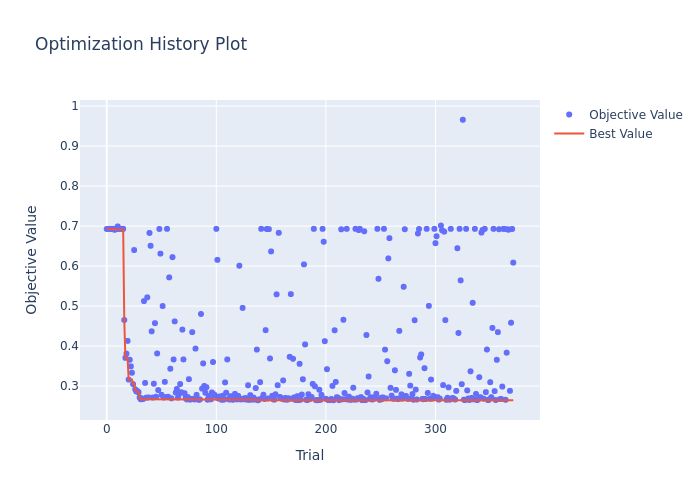

In [11]:
plot_optimization_history(study)

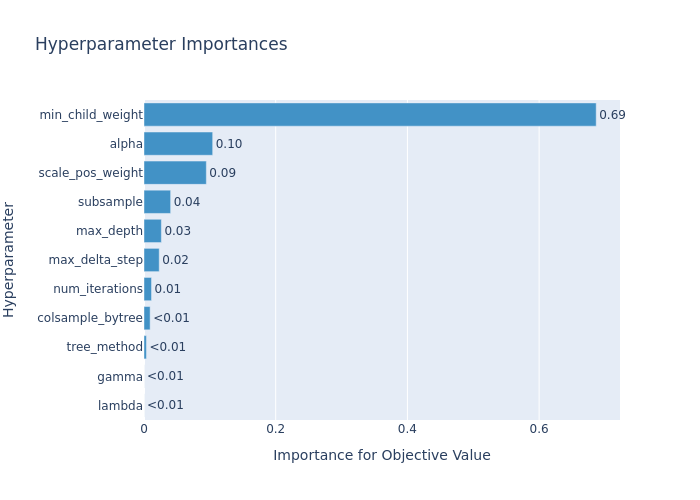

In [12]:
plot_param_importances(study)

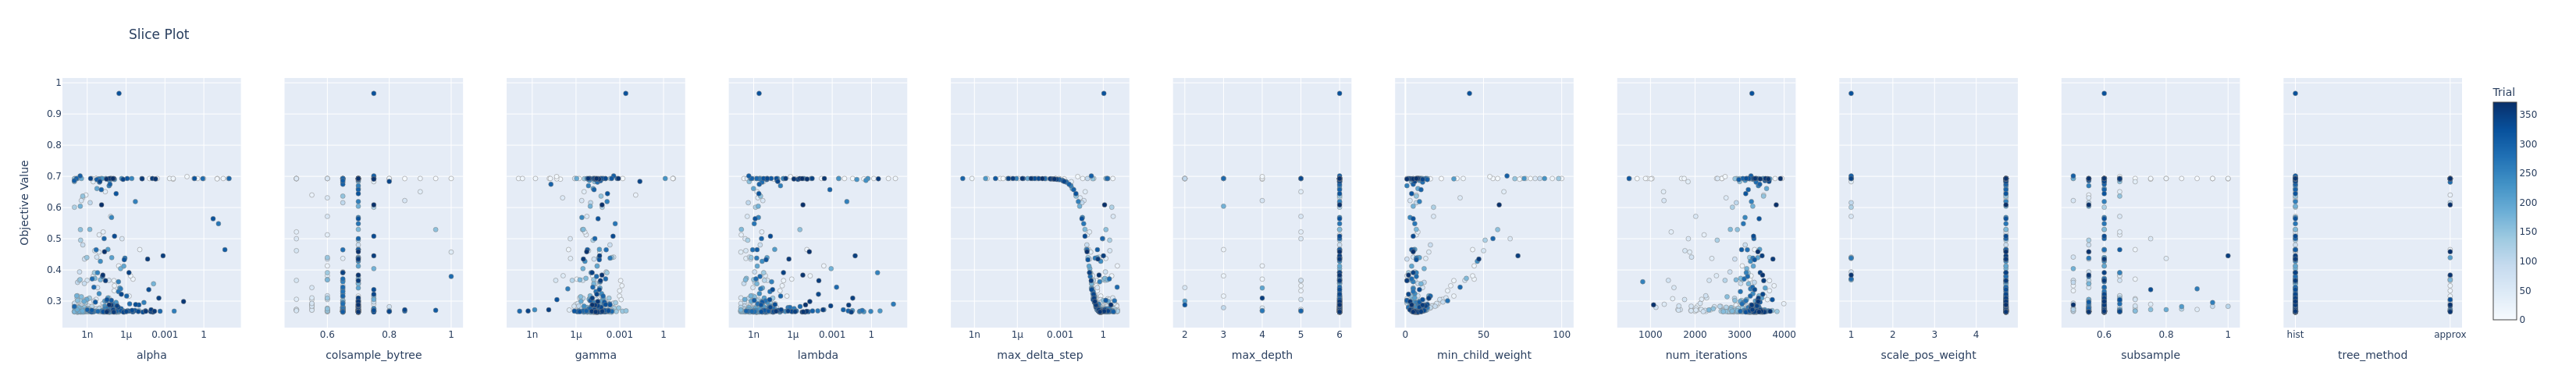

In [13]:
plot_slice(study)

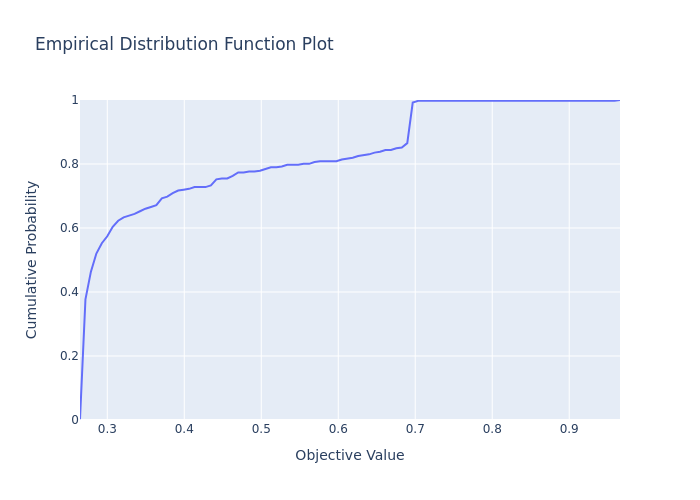

In [14]:
plot_edf(study)

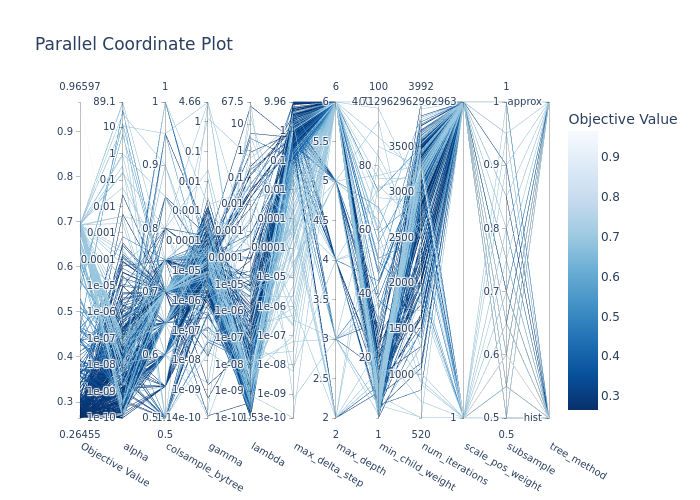

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'booster': 'gbtree',
 'grow_policy': 'depthwise',
 'objective': 'binary:logistic',
 'verbosity': 0,
 'seed': 2112,
 'eta': 0.005,
 'alpha': 1.6994352608068032e-10,
 'colsample_bytree': 0.65,
 'gamma': 0.0002696679879623113,
 'lambda': 1.0733197133336225e-08,
 'max_delta_step': 0.5654183860930762,
 'max_depth': 6,
 'min_child_weight': 6,
 'num_iterations': 3478,
 'scale_pos_weight': 4.712962962962963,
 'subsample': 0.6,
 'tree_method': 'hist'}

***